# An In-Depth Look at Home Court Advantage


Importing the Libraries

In [1]:
from pandas import Series, DataFrame
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sn
%pylab inline
%config InlineBackend.figure_format='retina'

Populating the interactive namespace from numpy and matplotlib


Importing the Teams Details CSV

In [2]:
df_team_names = pd.read_csv('teams.csv')
df_team_names = df_team_names[['TEAM_ID', 'ABBREVIATION']]

Importing the games CSV

In [3]:
df_games = pd.read_csv('games.csv', parse_dates = ['GAME_DATE_EST'])
df_games = df_games.drop(['GAME_STATUS_TEXT', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID'], axis = 1)

df_games.drop_duplicates(inplace=True)
df_games.head()

,GAME_DATE_EST,GAME_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
0,2021-05-26,42000102,2020,1610612755,120.0,0.557,0.684,0.429,26.0,45.0,1610612764,95.0,0.402,0.633,0.091,22.0,40.0,1
1,2021-05-26,42000132,2020,1610612752,101.0,0.383,0.739,0.364,15.0,54.0,1610612737,92.0,0.369,0.818,0.273,17.0,41.0,1
2,2021-05-26,42000142,2020,1610612762,141.0,0.544,0.774,0.487,28.0,42.0,1610612763,129.0,0.541,0.763,0.348,20.0,33.0,1
3,2021-05-25,42000112,2020,1610612751,130.0,0.523,0.955,0.447,31.0,46.0,1610612738,108.0,0.424,0.783,0.353,23.0,43.0,1
4,2021-05-25,42000152,2020,1610612756,102.0,0.465,0.933,0.308,21.0,31.0,1610612747,109.0,0.450,0.871,0.303,24.0,39.0,0


Fetching the home and away team abbreviation from the team details dataframe to the main games dataframe

In [4]:
df_games = df_games.merge(df_team_names, left_on = 'TEAM_ID_home', right_on = 'TEAM_ID')
df_games = df_games.drop(['TEAM_ID'], axis = 1)
df_games.rename(columns = {'ABBREVIATION':'HOME_TEAM'}, inplace = True)

df_games = df_games.merge(df_team_names, left_on = 'TEAM_ID_away', right_on = 'TEAM_ID')
df_games = df_games.drop(['TEAM_ID'], axis = 1)
df_games.rename(columns = {'ABBREVIATION':'AWAY_TEAM'}, inplace = True)

#create column to determine if the away team won
df_games['AWAY_TEAM_WINS'] = df_games['HOME_TEAM_WINS'].apply(lambda x: 1 if x==0 else 0)

#create column calculating the difference in points between the home team and away team
df_games['POINT_DIFFERENTIAL'] = df_games['PTS_home'] - df_games['PTS_away'] 
df_games.dropna(how='any', inplace=True)

Initializing the Games Details CSV and removing players that played less than 2 minutes or more than 90 minutes in the whole game.

In [5]:
def convert_to_min(x):
    if pd.isna(x):
        return 0
    
    x = str(x).split(':')
    if len(x) < 2:
        return int(x[0])*60
    else: 
        return int(x[0])*60+int(x[1])


df_games_details = pd.read_csv('games_details.csv')
df_games_details['SECONDS_PLAYED'] = df_games_details['MIN'].apply(convert_to_min)
df_games_details['SECONDS_PLAYED'] = pd.to_numeric(df_games_details['SECONDS_PLAYED'])
df_games_details.dropna(how='any', subset=['PLUS_MINUS'], inplace=True)

#668 and 3460 are the outlier boundary according to 1.5*IQR
df_games_details = df_games_details[(df_games_details['SECONDS_PLAYED'] >= 668) & (df_games_details['SECONDS_PLAYED'] <= 3460)]

## Distribution of Point Differential

This plot shows frequency of the difference in points between the home team and away team. Because the distribution is left skewed, we can conclude there are more games in which the home team has won. 

Text(0.5, 1.0, 'Point Differential Frequency Distribution')

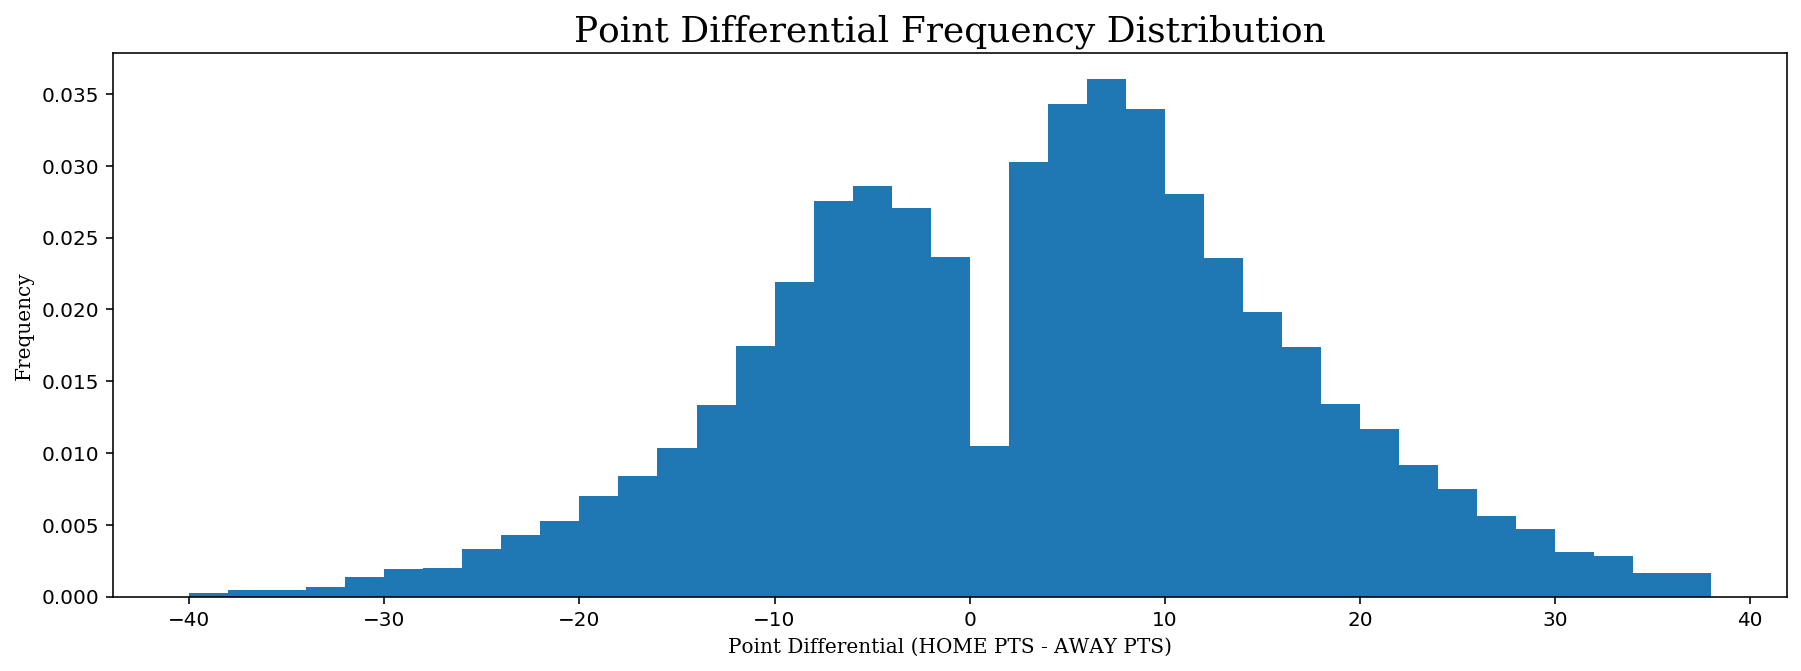

In [6]:
bin_size = range(-40, 40, 2)
df_games['POINT_DIFFERENTIAL'].plot(kind='hist', bins=bin_size,  density=True, figsize = (15,5))

font1 = {'family':'serif','color':'black','size':18}
font2 = {'family':'serif','color':'black'}

ylabel('Frequency', fontdict = font2)
xlabel('Point Differential (HOME PTS - AWAY PTS)', fontdict = font2)
title('Point Differential Frequency Distribution', fontdict = font1)


# Metrics Comparison - Season Level

This section aims to compare home-court advantage in a time series across seasons from 2004 to 2020. 

In [7]:
df_season = df_games.groupby('SEASON')[['HOME_TEAM_WINS', 'POINT_DIFFERENTIAL']].mean()

Text(0.5, 1.0, 'Home Team Point Differential Over Seasons')

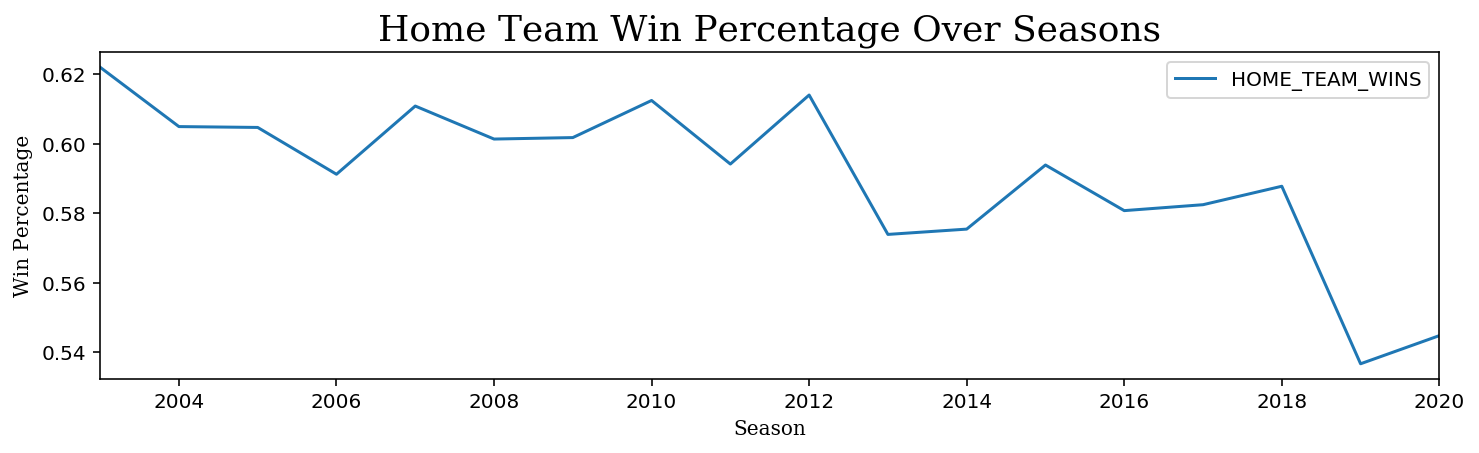

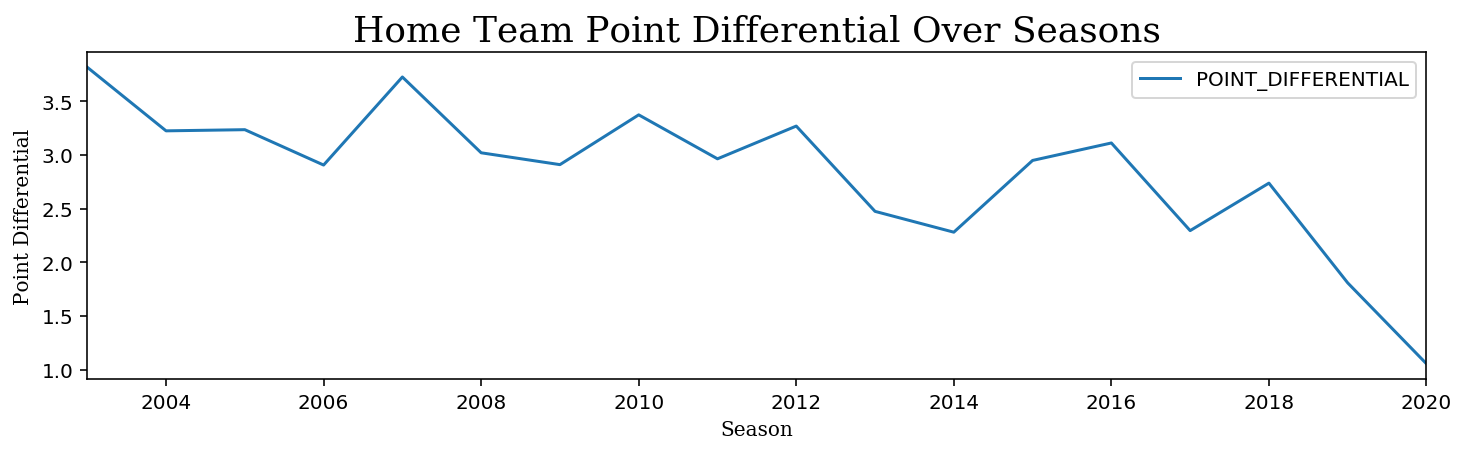

In [8]:
#Change in Home Team Win Percentage and Point Differential over time
df_season.plot(y = 'HOME_TEAM_WINS', kind='line', figsize = (12,3))
ylabel('Win Percentage', fontdict = font2)
xlabel('Season', fontdict = font2)
title('Home Team Win Percentage Over Seasons', fontdict = font1)

df_season.plot(y = 'POINT_DIFFERENTIAL', kind = 'line', figsize = (12,3))
ylabel('Point Differential', fontdict = font2)
xlabel('Season', fontdict = font2)
title('Home Team Point Differential Over Seasons', fontdict = font1)


From 2004-2018, teams won at least 58% of home games by a minimum of a 2.28 point lead. The sharp decline in 2019 can be attributed to the COVID-19 pandemic and its impact on fan attendance. This will be explored more later.

# Metrics Comparison -Team Level

This section aims to compare key performance metrics among NBA teams in both their home and away games.

Text(0.5, 1.0, 'Win Ratio - Home Vs Away')

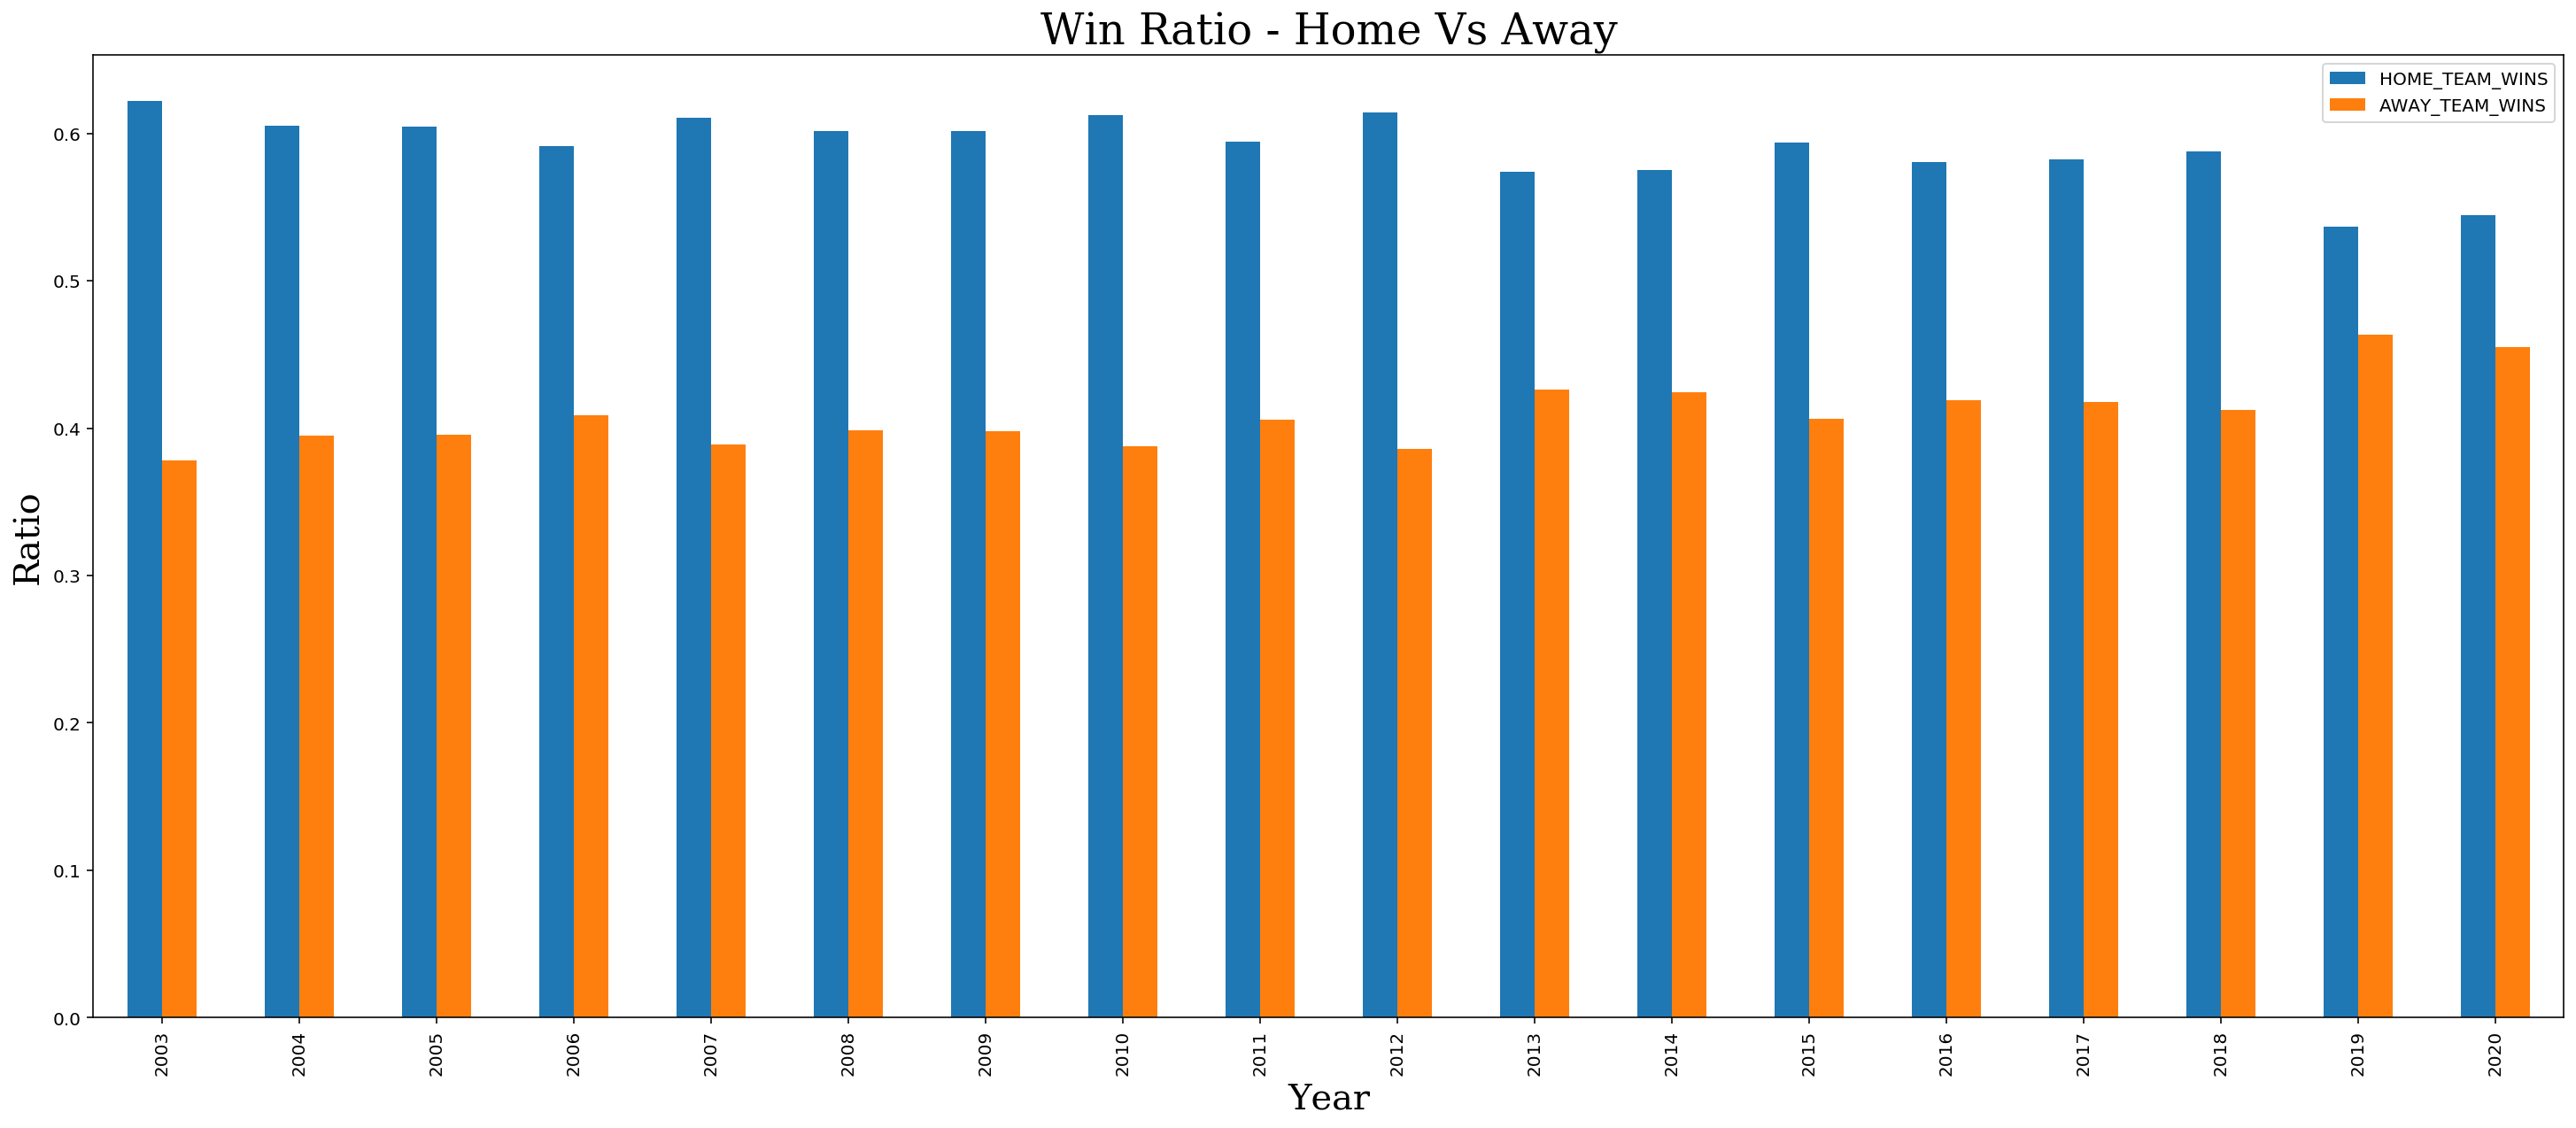

In [9]:
df_home_teams = df_games.groupby('HOME_TEAM')['PTS_home', 'AST_home', 'FT_PCT_home', 'REB_home', 'FG3_PCT_home', 'FG_PCT_home', 'HOME_TEAM_WINS'].agg('mean')
df_away_teams = df_games.groupby('AWAY_TEAM')['PTS_away', 'AST_away', 'FT_PCT_away', 'REB_away', 'FG3_PCT_away', 'FG_PCT_away', 'AWAY_TEAM_WINS'].agg('mean')

df_home_vs_away = df_home_teams.join(df_away_teams, how = 'outer')

font3 = {'family':'serif','color':'black','size':24}
font4 = {'family':'serif','color':'black', 'size':20}

pts_plot = df_season = df_games.groupby('SEASON')['HOME_TEAM_WINS', 'AWAY_TEAM_WINS'].mean().plot(kind='bar', figsize = (25,10))
legend(loc = 1)
ylabel('Ratio', fontdict = font4)
xlabel('Year', fontdict = font4)
title('Win Ratio - Home Vs Away', fontdict = font3)



Text(0.5, 1.0, 'Points - Home Vs Away')

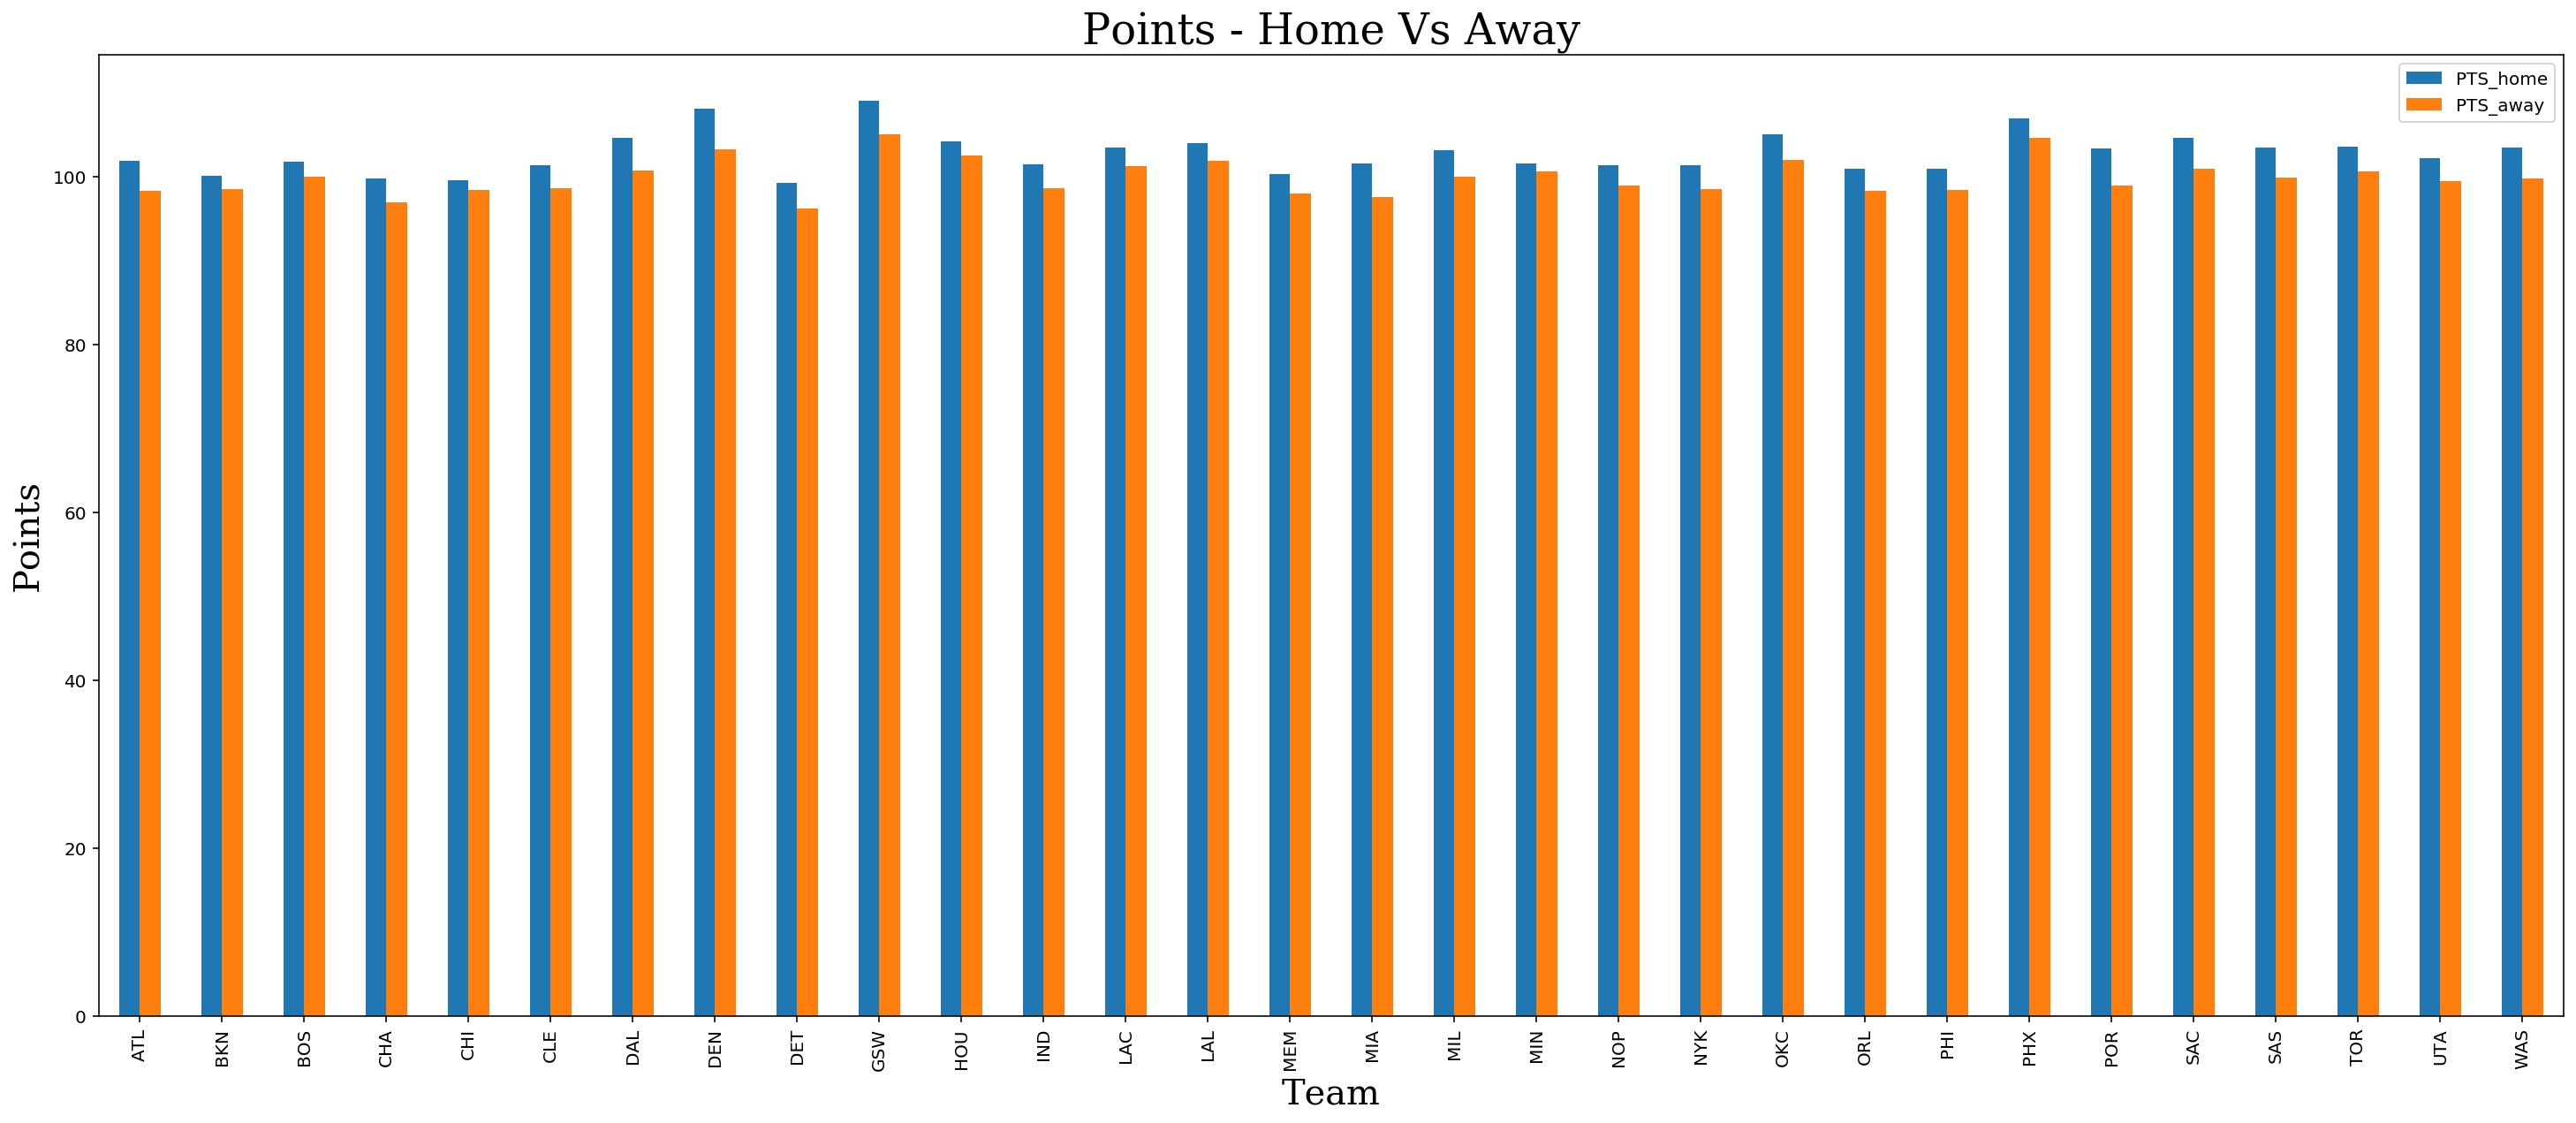

In [10]:
pts_plot = df_home_vs_away[['PTS_home',"PTS_away"]].plot(kind = 'bar', figsize = (25,10))
legend(loc = 1)
ylabel('Points', fontdict = font4)
xlabel('Team', fontdict = font4)
title('Points - Home Vs Away', fontdict = font3)

Text(0.5, 1.0, 'Assists - Home Vs Away')

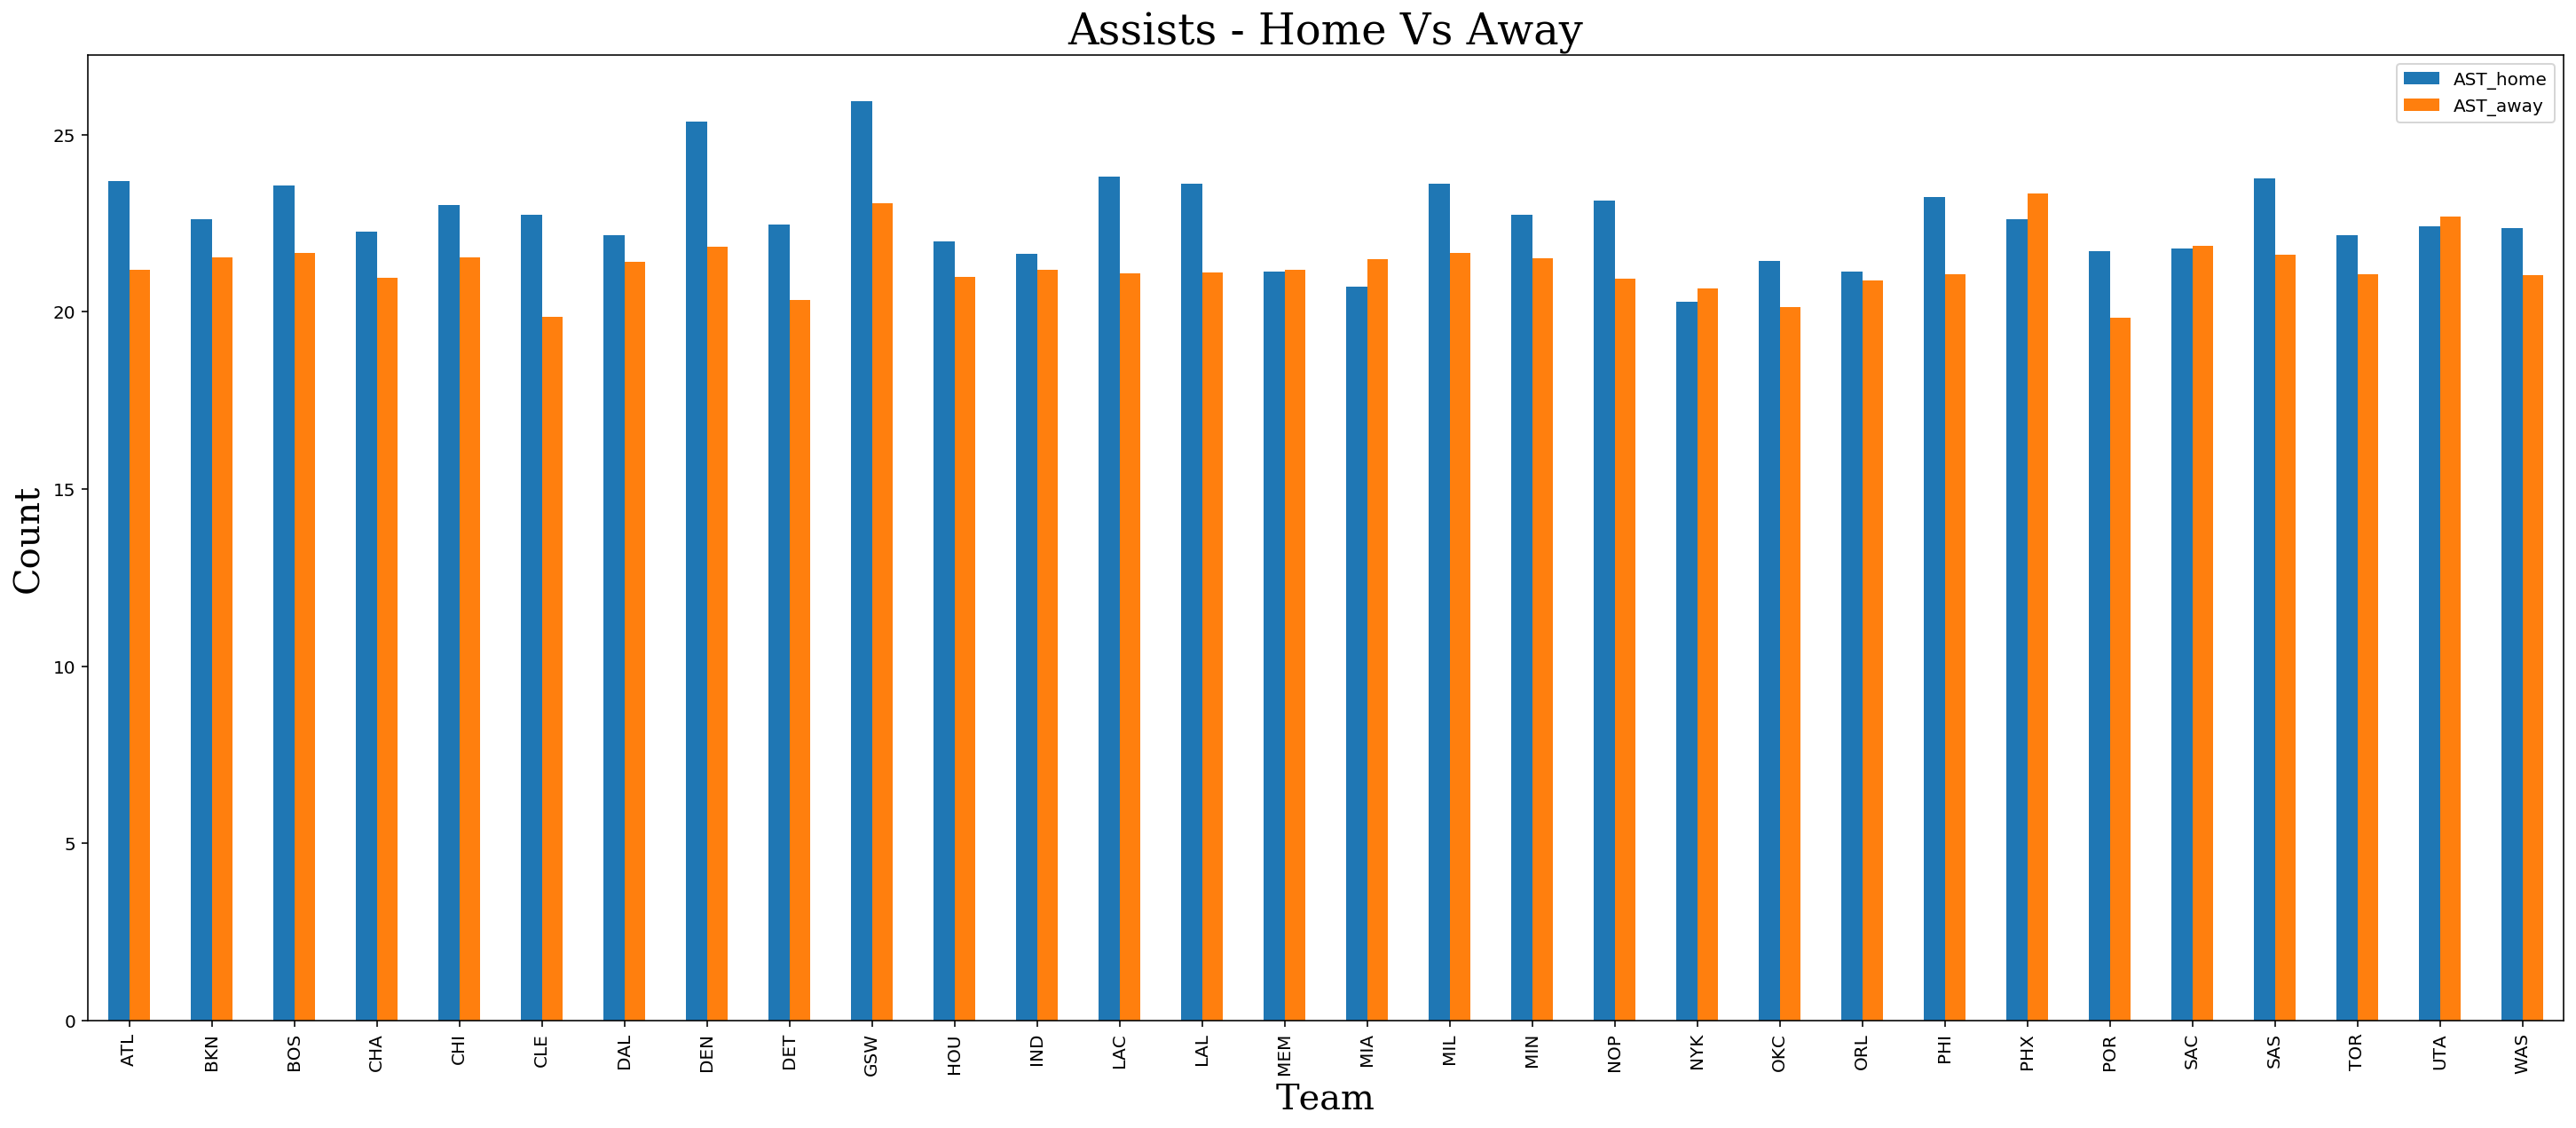

In [11]:
pts_ast = df_home_vs_away[['AST_home',"AST_away"]].plot(kind = 'bar', figsize = (25,10))
legend(loc = 1)
ylabel('Count', fontdict = font4)
xlabel('Team', fontdict = font4)
title('Assists - Home Vs Away', fontdict = font3)


Text(0.5, 1.0, 'Free Throw Percentage - Home Vs Away')

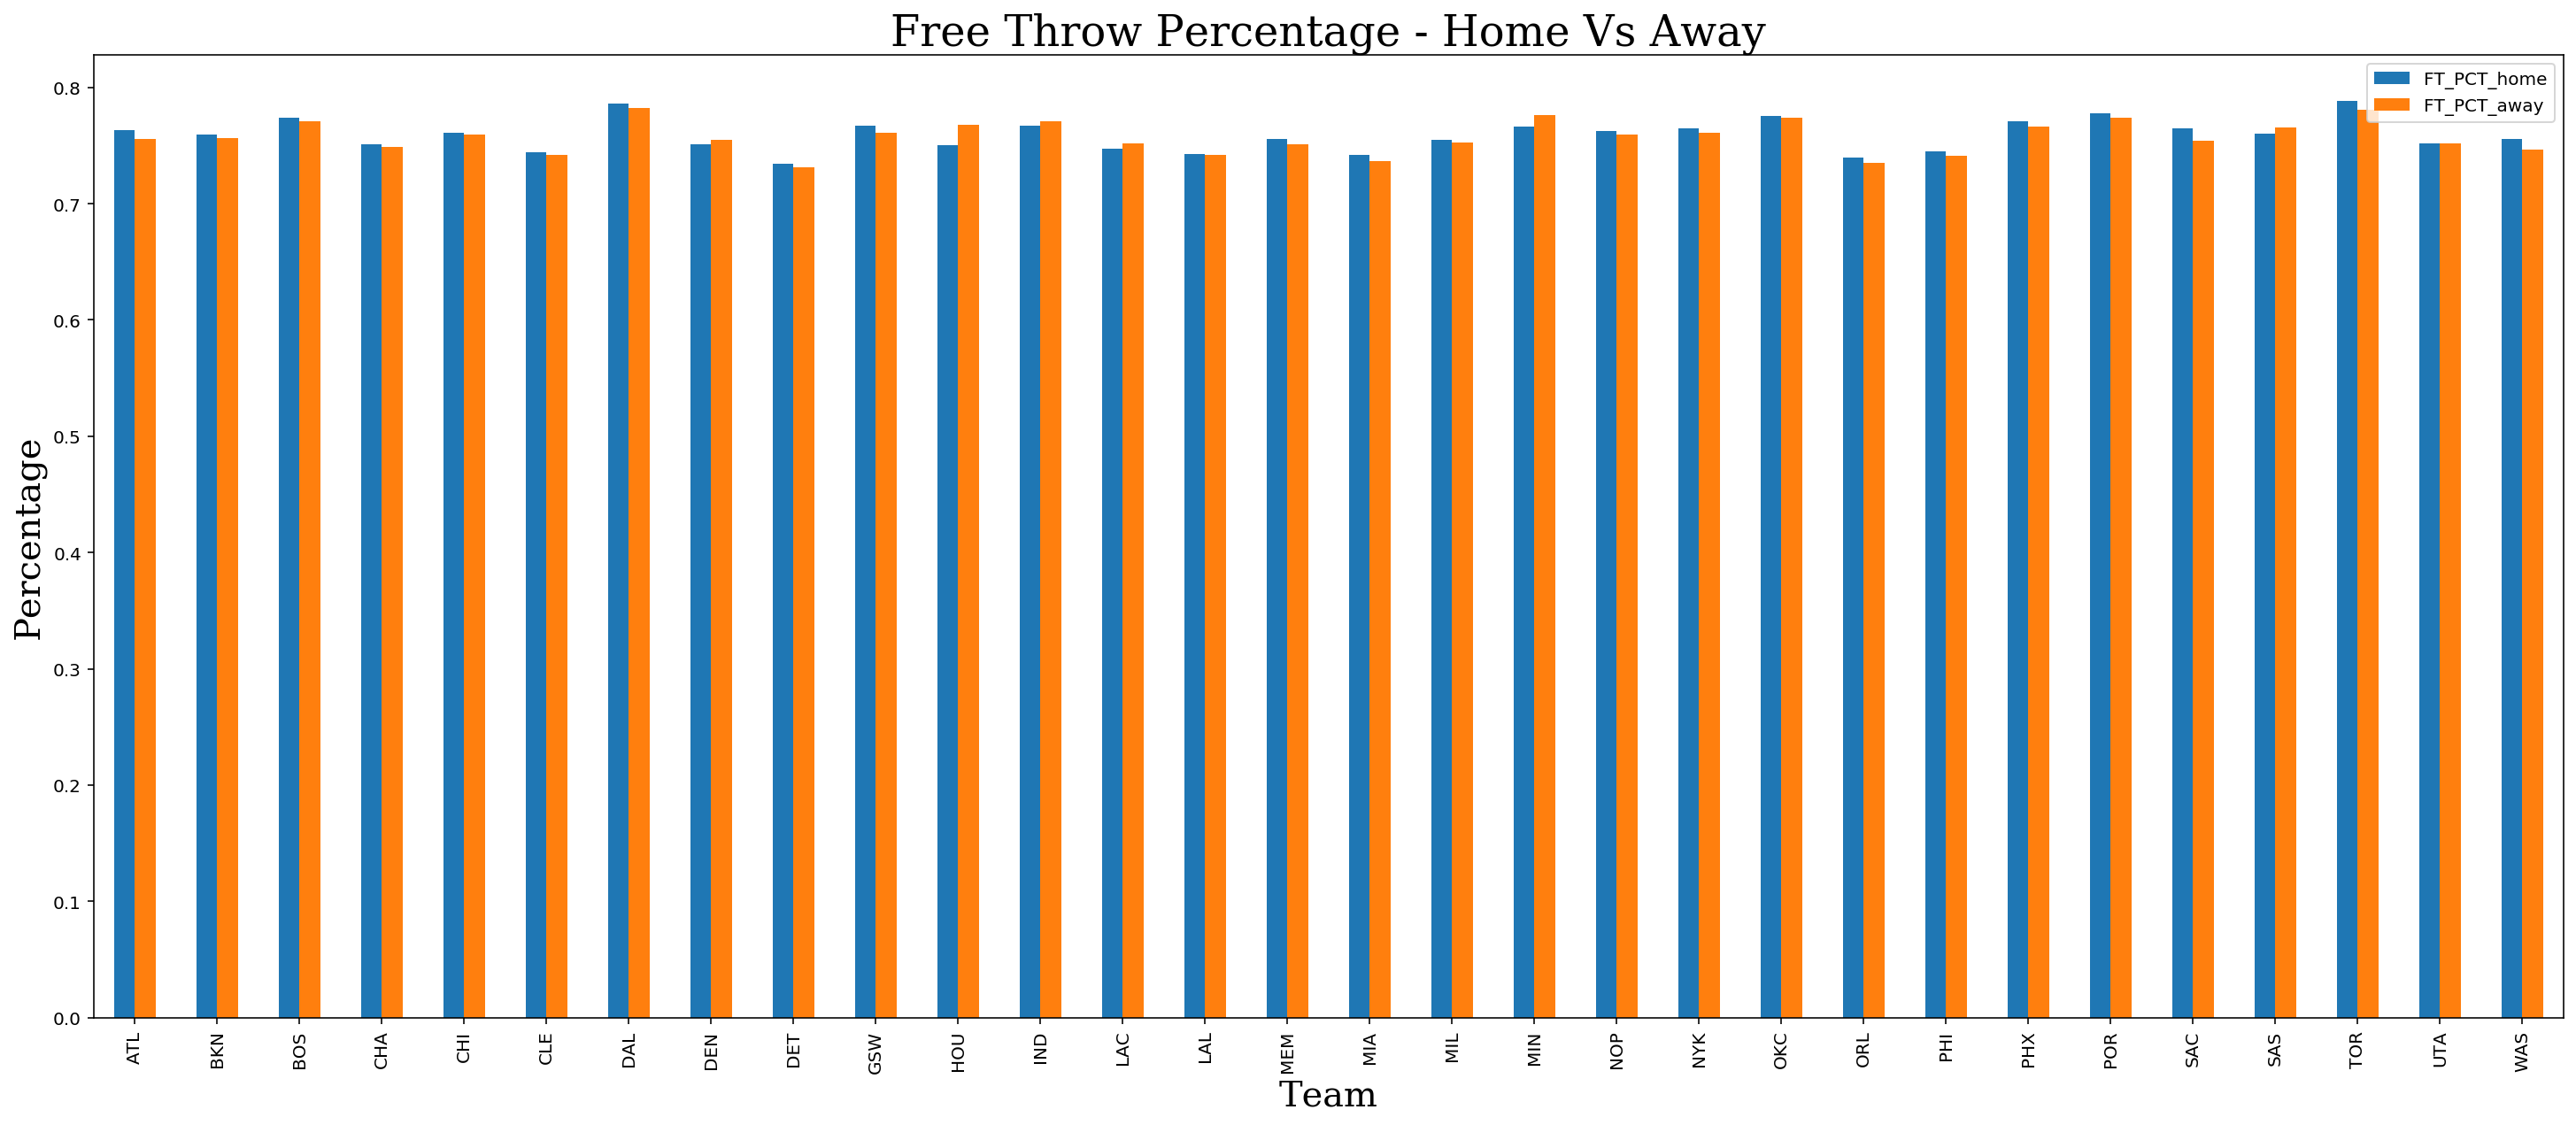

In [12]:
pts_FT_PCT = df_home_vs_away[['FT_PCT_home',"FT_PCT_away"]].plot(kind = 'bar', figsize = (25,10))
legend(loc = 1)
ylabel('Percentage', fontdict = font4)
xlabel('Team', fontdict = font4)
title('Free Throw Percentage - Home Vs Away', fontdict = font3)


Text(0.5, 1.0, 'Rebounds - Home Vs Away')

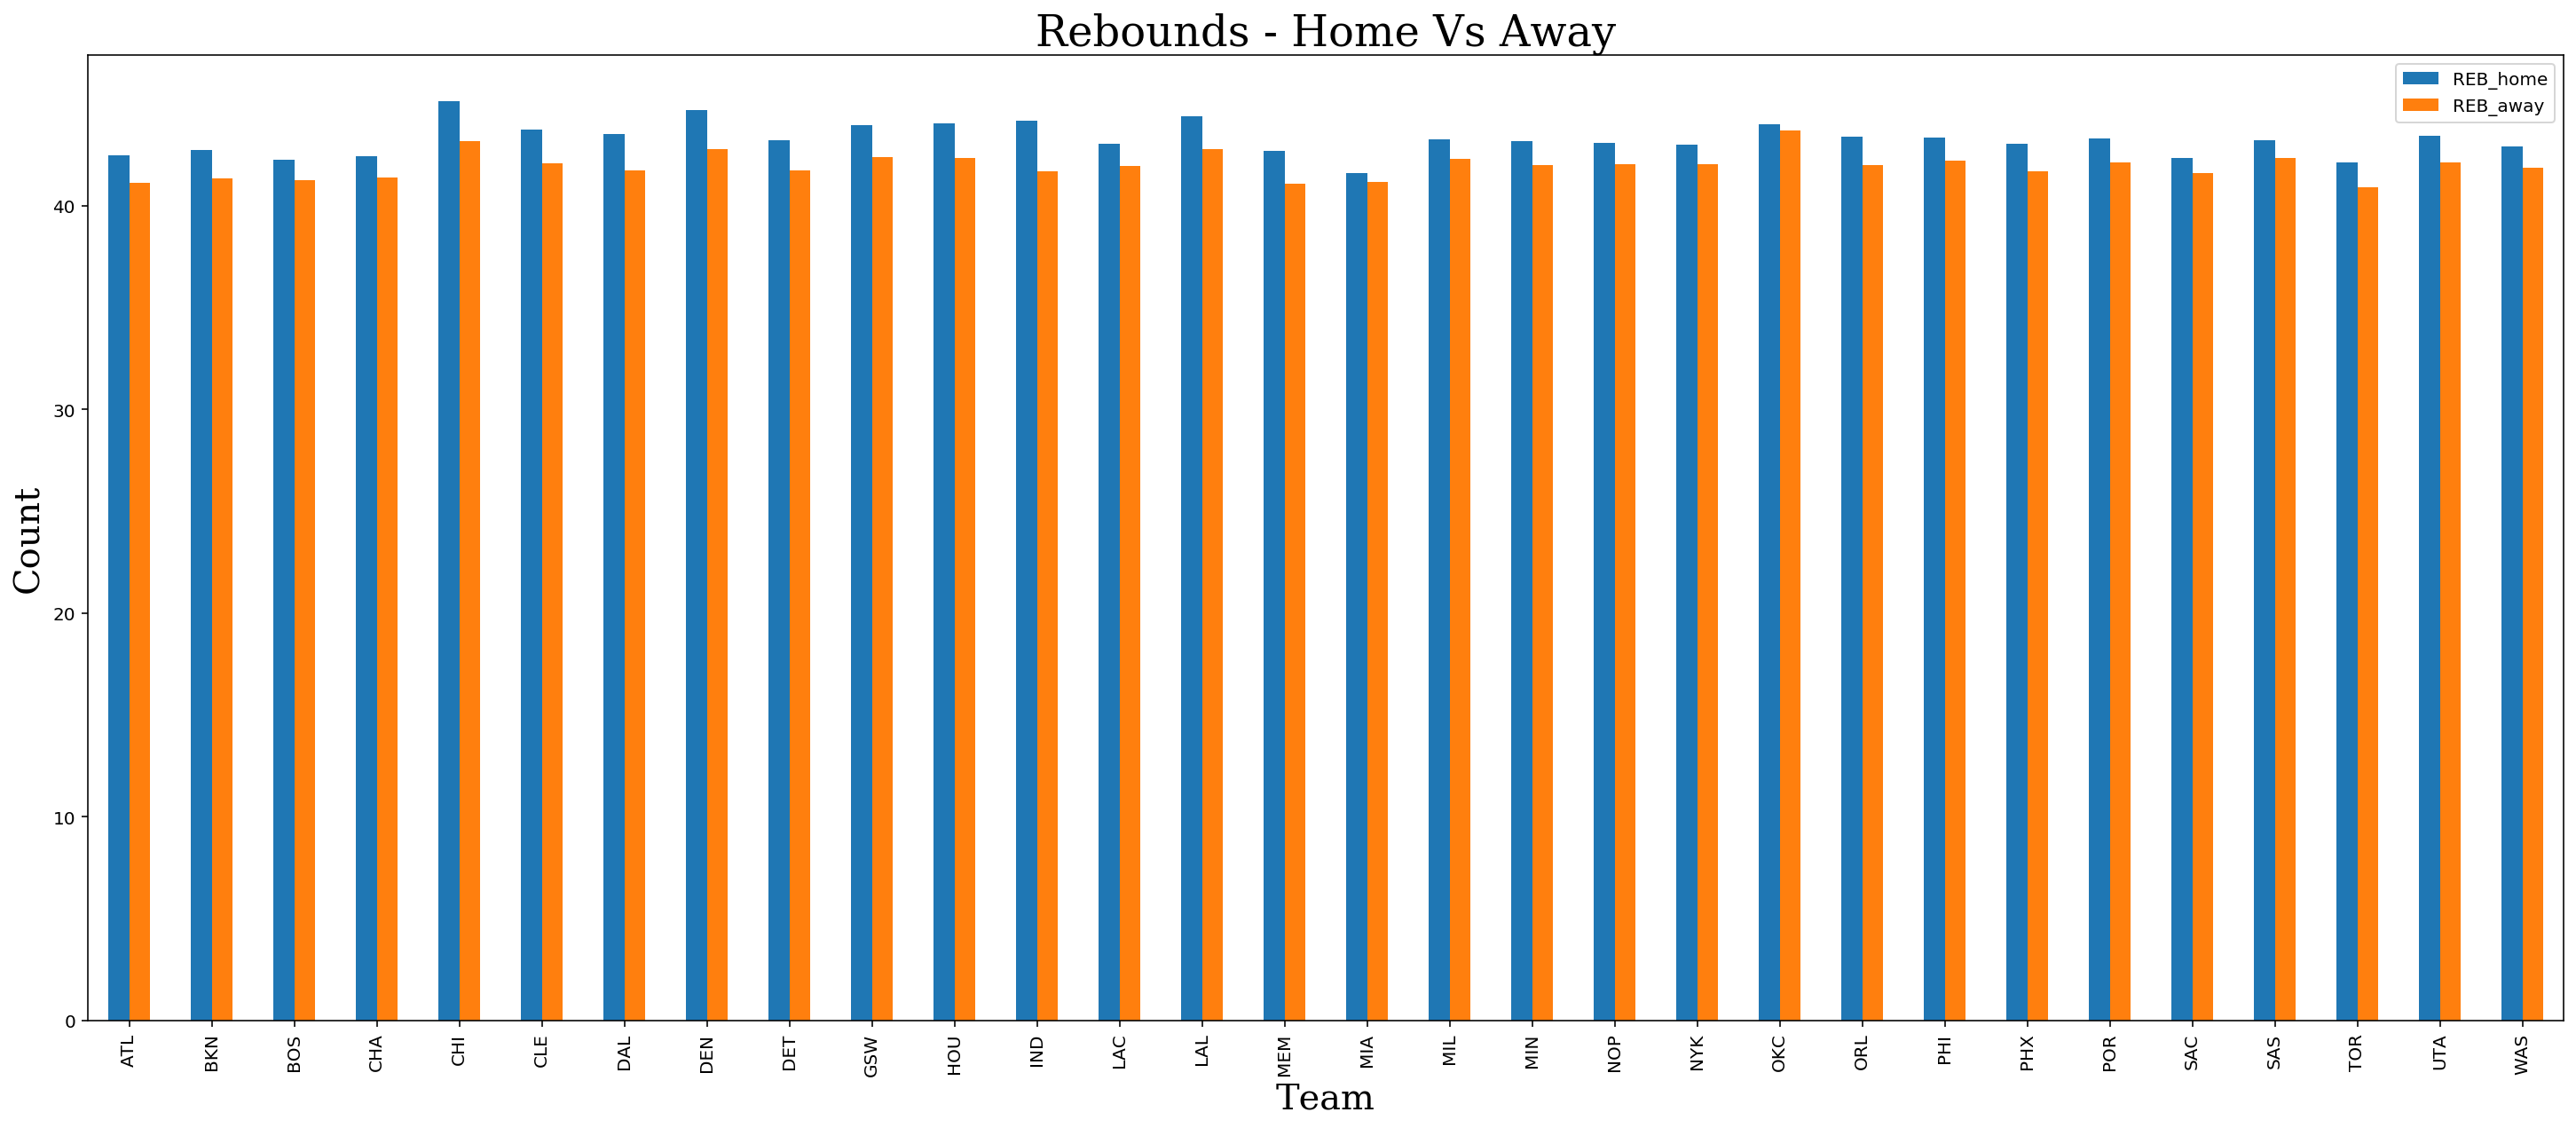

In [13]:
pts__REB = df_home_vs_away[['REB_home',"REB_away"]].plot(kind = 'bar', figsize = (25,10))
legend(loc = 1)

ylabel('Count', fontdict = font4)
xlabel('Team', fontdict = font4)
title('Rebounds - Home Vs Away', fontdict = font3)


Text(0.5, 1.0, 'Field Goal 3 Percentage - Home Vs Away')

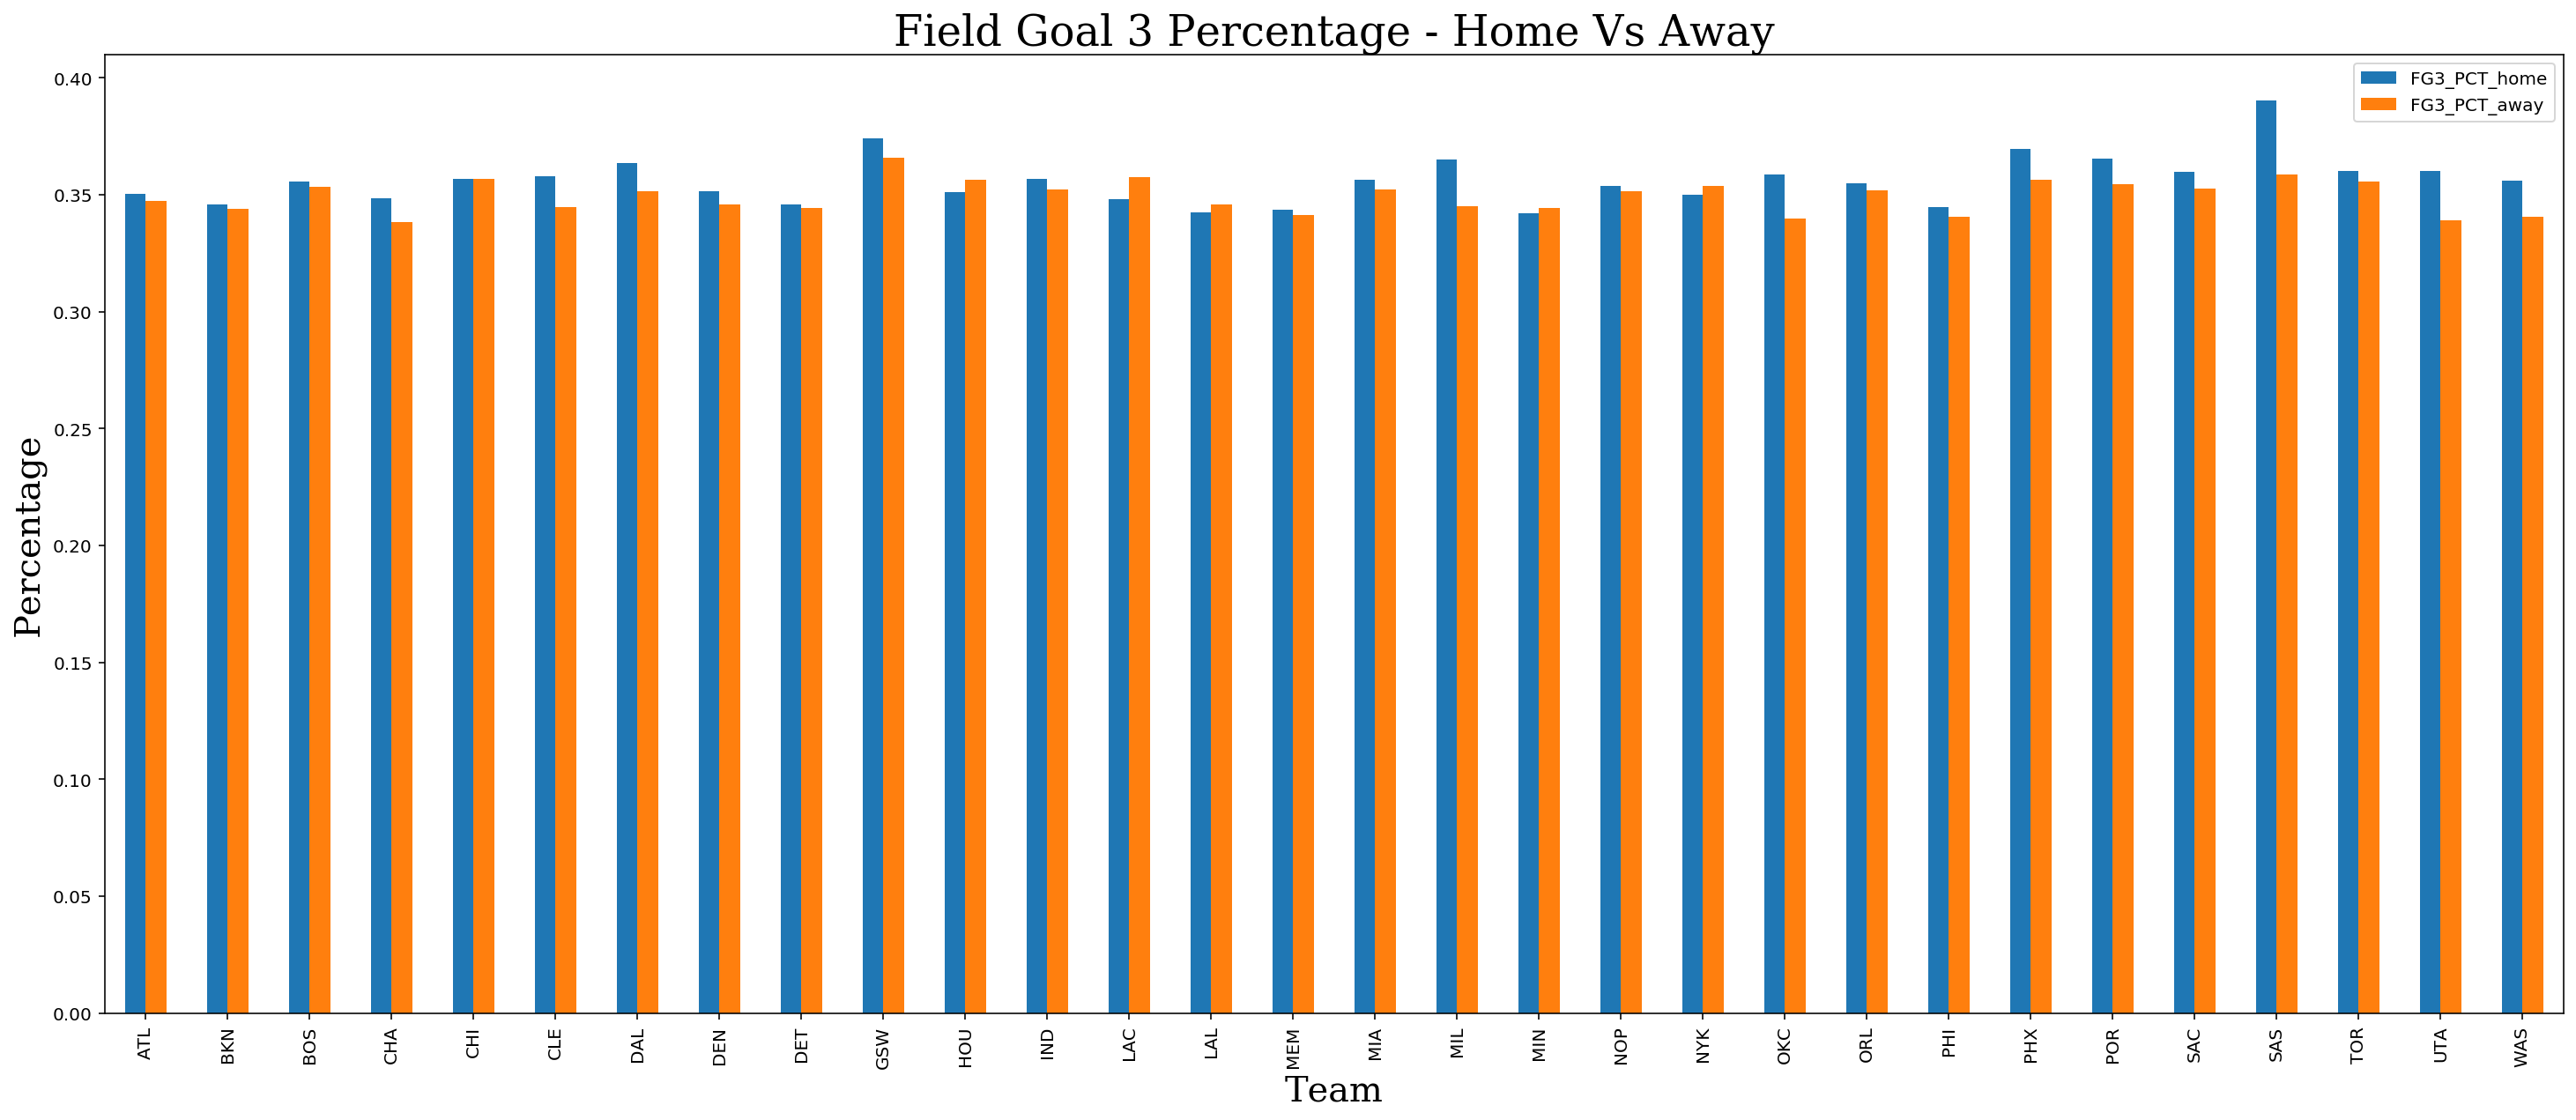

In [14]:
pts_FG3 = df_home_vs_away[['FG3_PCT_home',"FG3_PCT_away"]].plot(kind = 'bar', figsize = (25,10))
legend(loc = 1)
ylabel('Percentage', fontdict = font4)
xlabel('Team', fontdict = font4)
title('Field Goal 3 Percentage - Home Vs Away', fontdict = font3)


Text(0.5, 1.0, 'Field Goal Percentage - Home Vs Away')

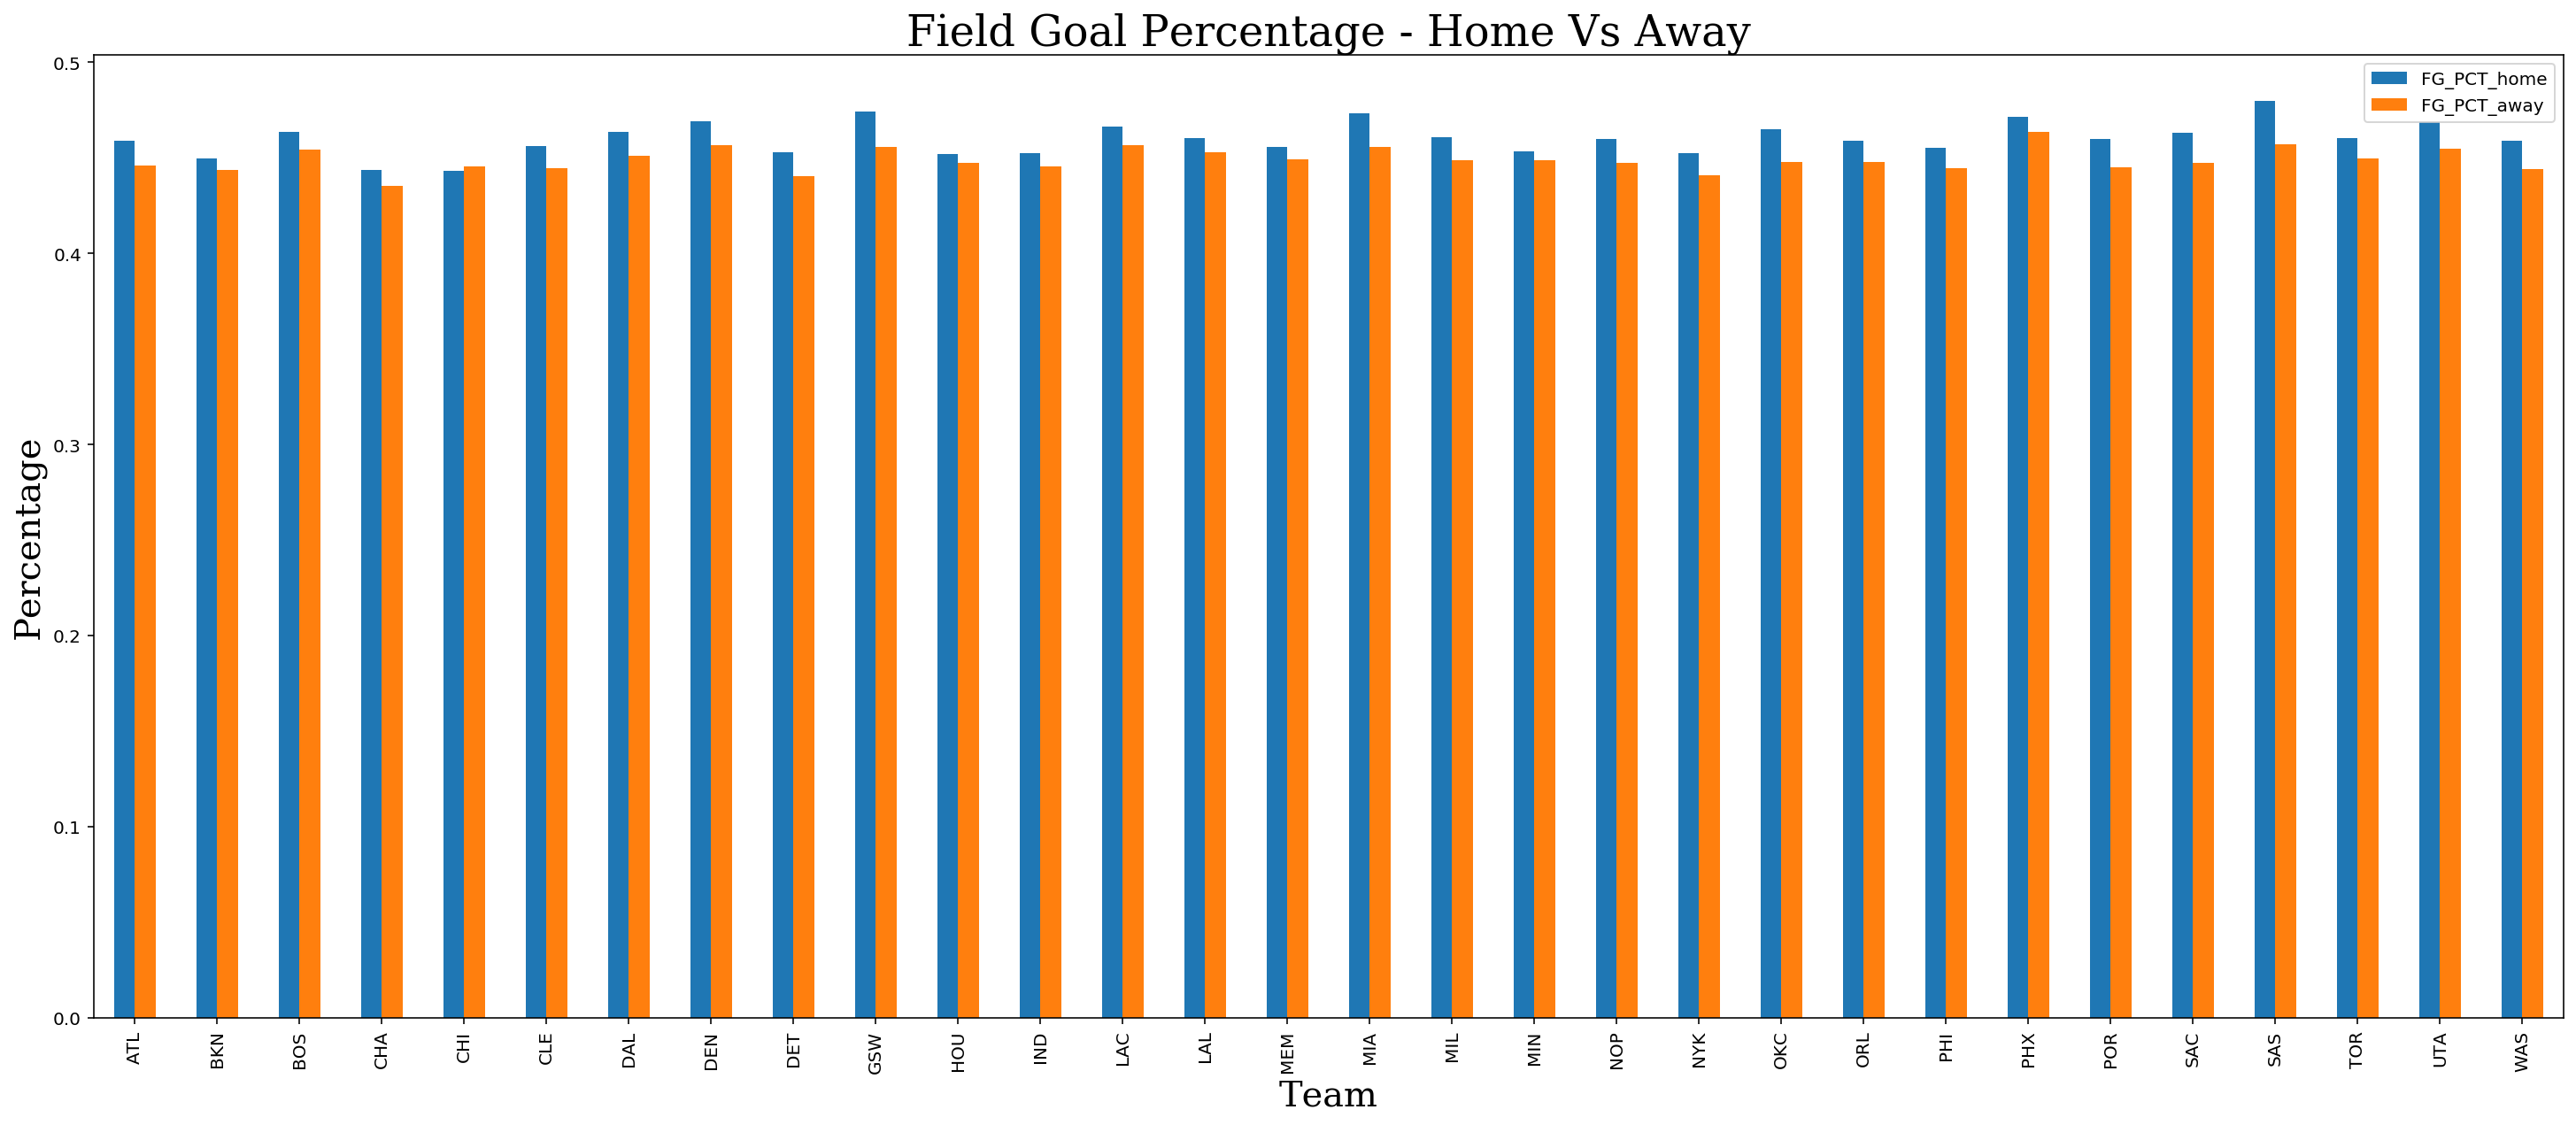

In [15]:
pts_FG_PCT = df_home_vs_away[['FG_PCT_home',"FG_PCT_away"]].plot(kind = 'bar', figsize = (25,10))
legend(loc = 1)
ylabel('Percentage', fontdict = font4)
xlabel('Team', fontdict = font4)
title('Field Goal Percentage - Home Vs Away', fontdict = font3)


Each team exhibits a clear better performance in each metric for their home games. 

The following section explores whether this pattern holds for the 2020 season, affected by the COVID-19 pandemic.

In [16]:
df_this_szn = df_games[df_games['GAME_DATE_EST']>='12/23/20']

df_home_teams2021 = df_this_szn.groupby('HOME_TEAM')['PTS_home', 'AST_home', 'FT_PCT_home', 'REB_home', 'FG3_PCT_home', 'FG_PCT_home', 'HOME_TEAM_WINS'].agg('mean')
df_away_teams2021 = df_this_szn.groupby('AWAY_TEAM')['PTS_away', 'AST_away', 'FT_PCT_away', 'REB_away', 'FG3_PCT_away', 'FG_PCT_away', 'AWAY_TEAM_WINS'].agg('mean')
df_home_vs_away2021 = df_home_teams2021.join(df_away_teams2021, how = 'outer')

Text(0.5, 1.0, 'Wins - Home Vs Away (Season 2020)')

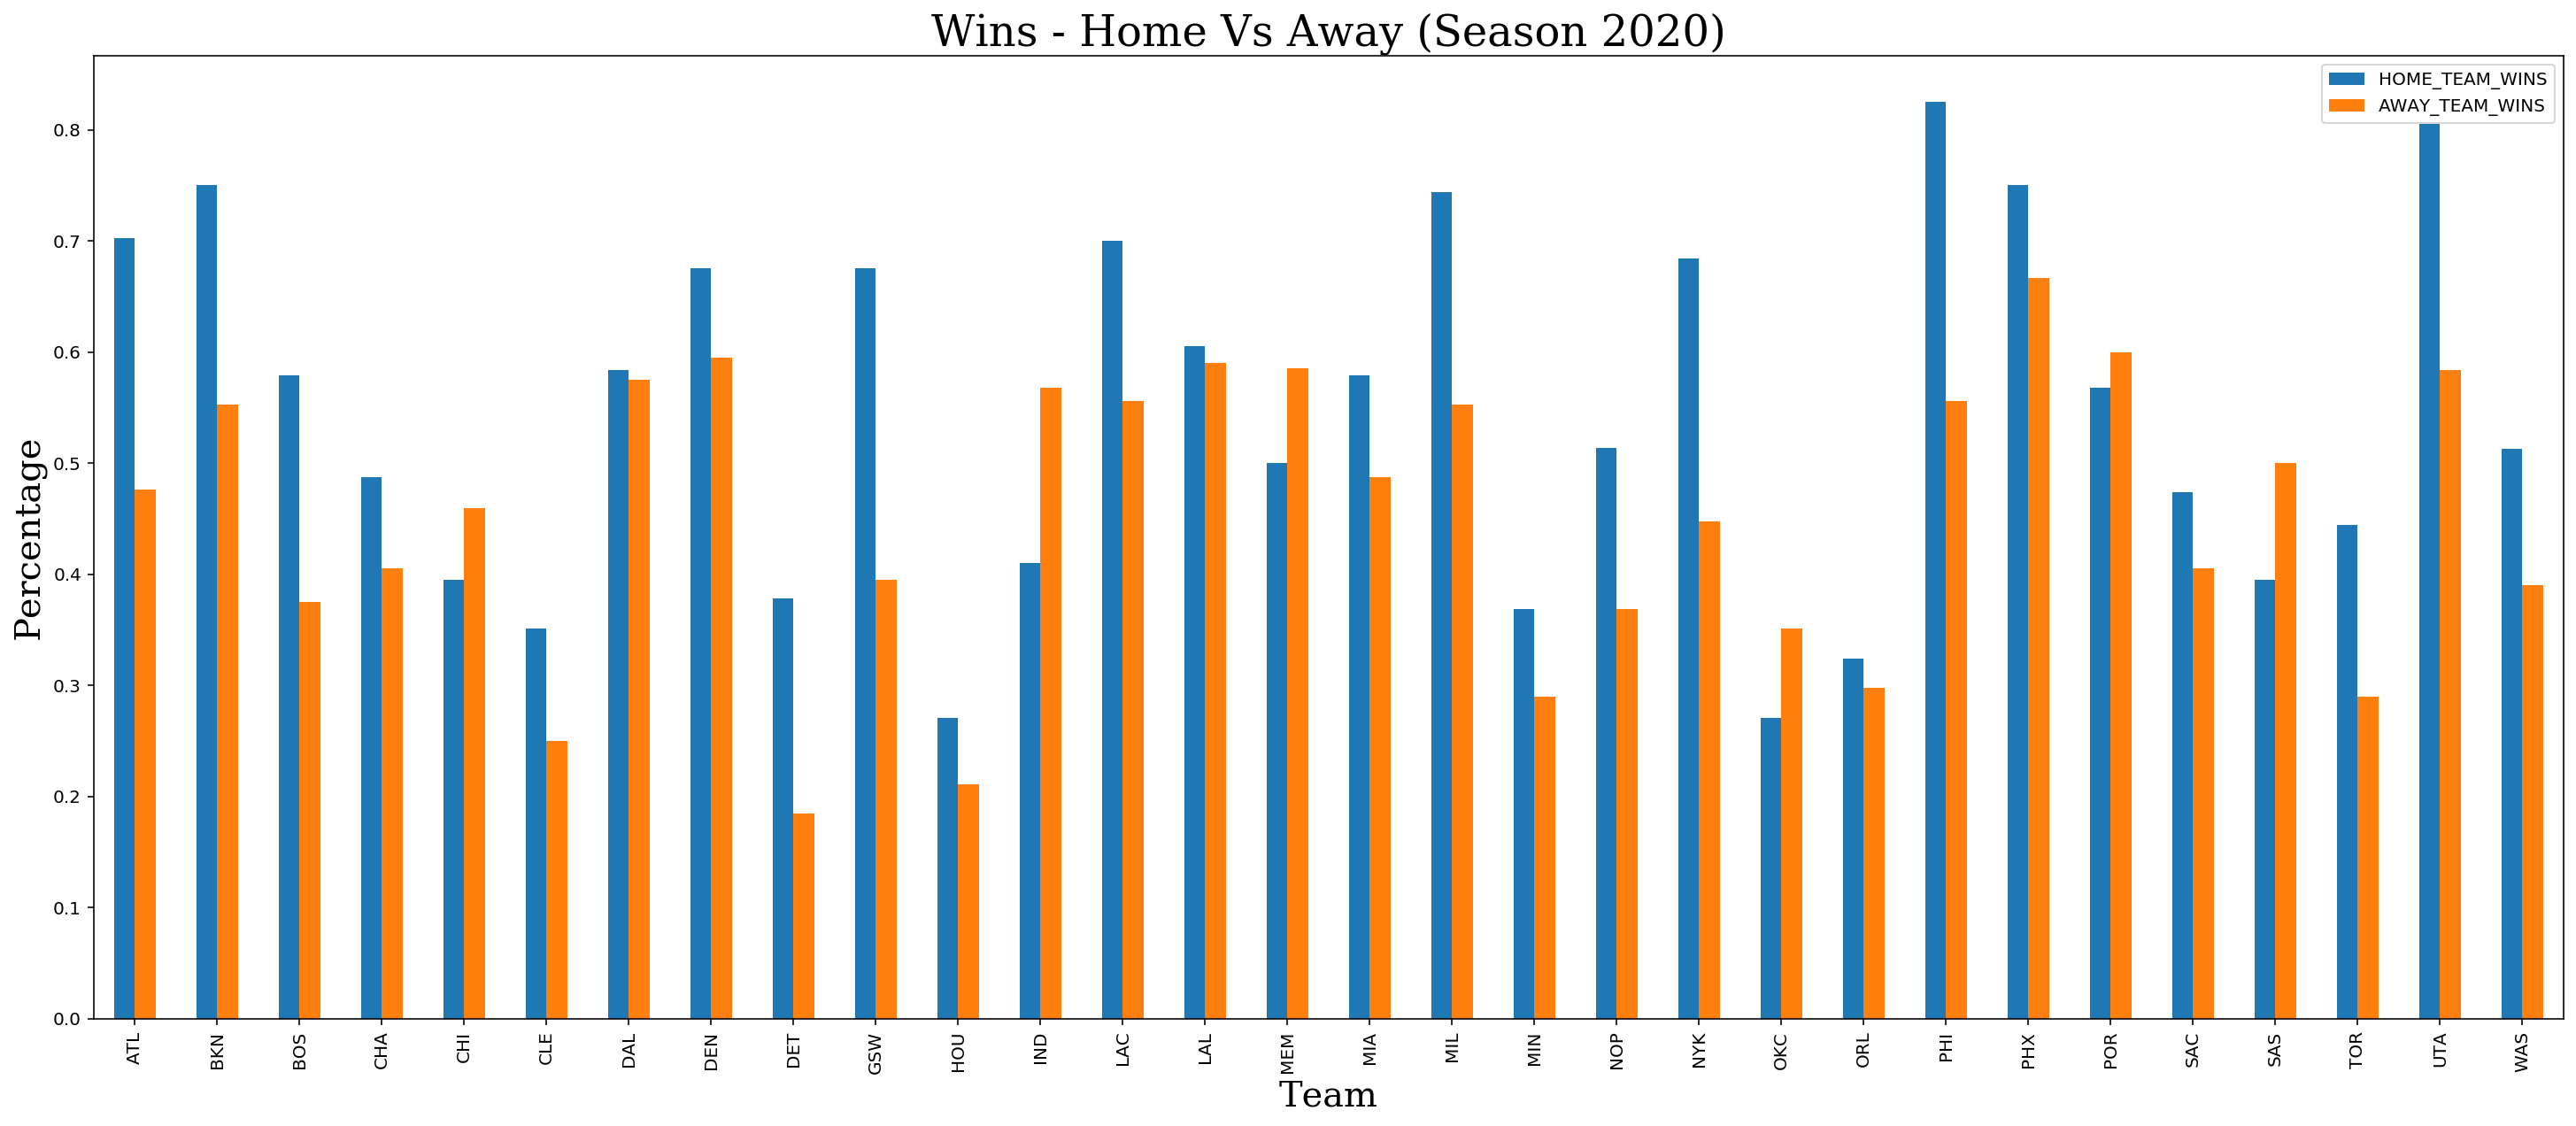

In [17]:
pts_FG_PCT = df_home_vs_away2021[['HOME_TEAM_WINS','AWAY_TEAM_WINS']].plot(kind = 'bar', figsize = (25,10))
legend(loc = 1)
ylabel('Percentage', fontdict = font4)
xlabel('Team', fontdict = font4)
title('Wins - Home Vs Away (Season 2020)', fontdict = font3)

Text(0.5, 1.0, 'Points - Home Vs Away (Season 2020)')

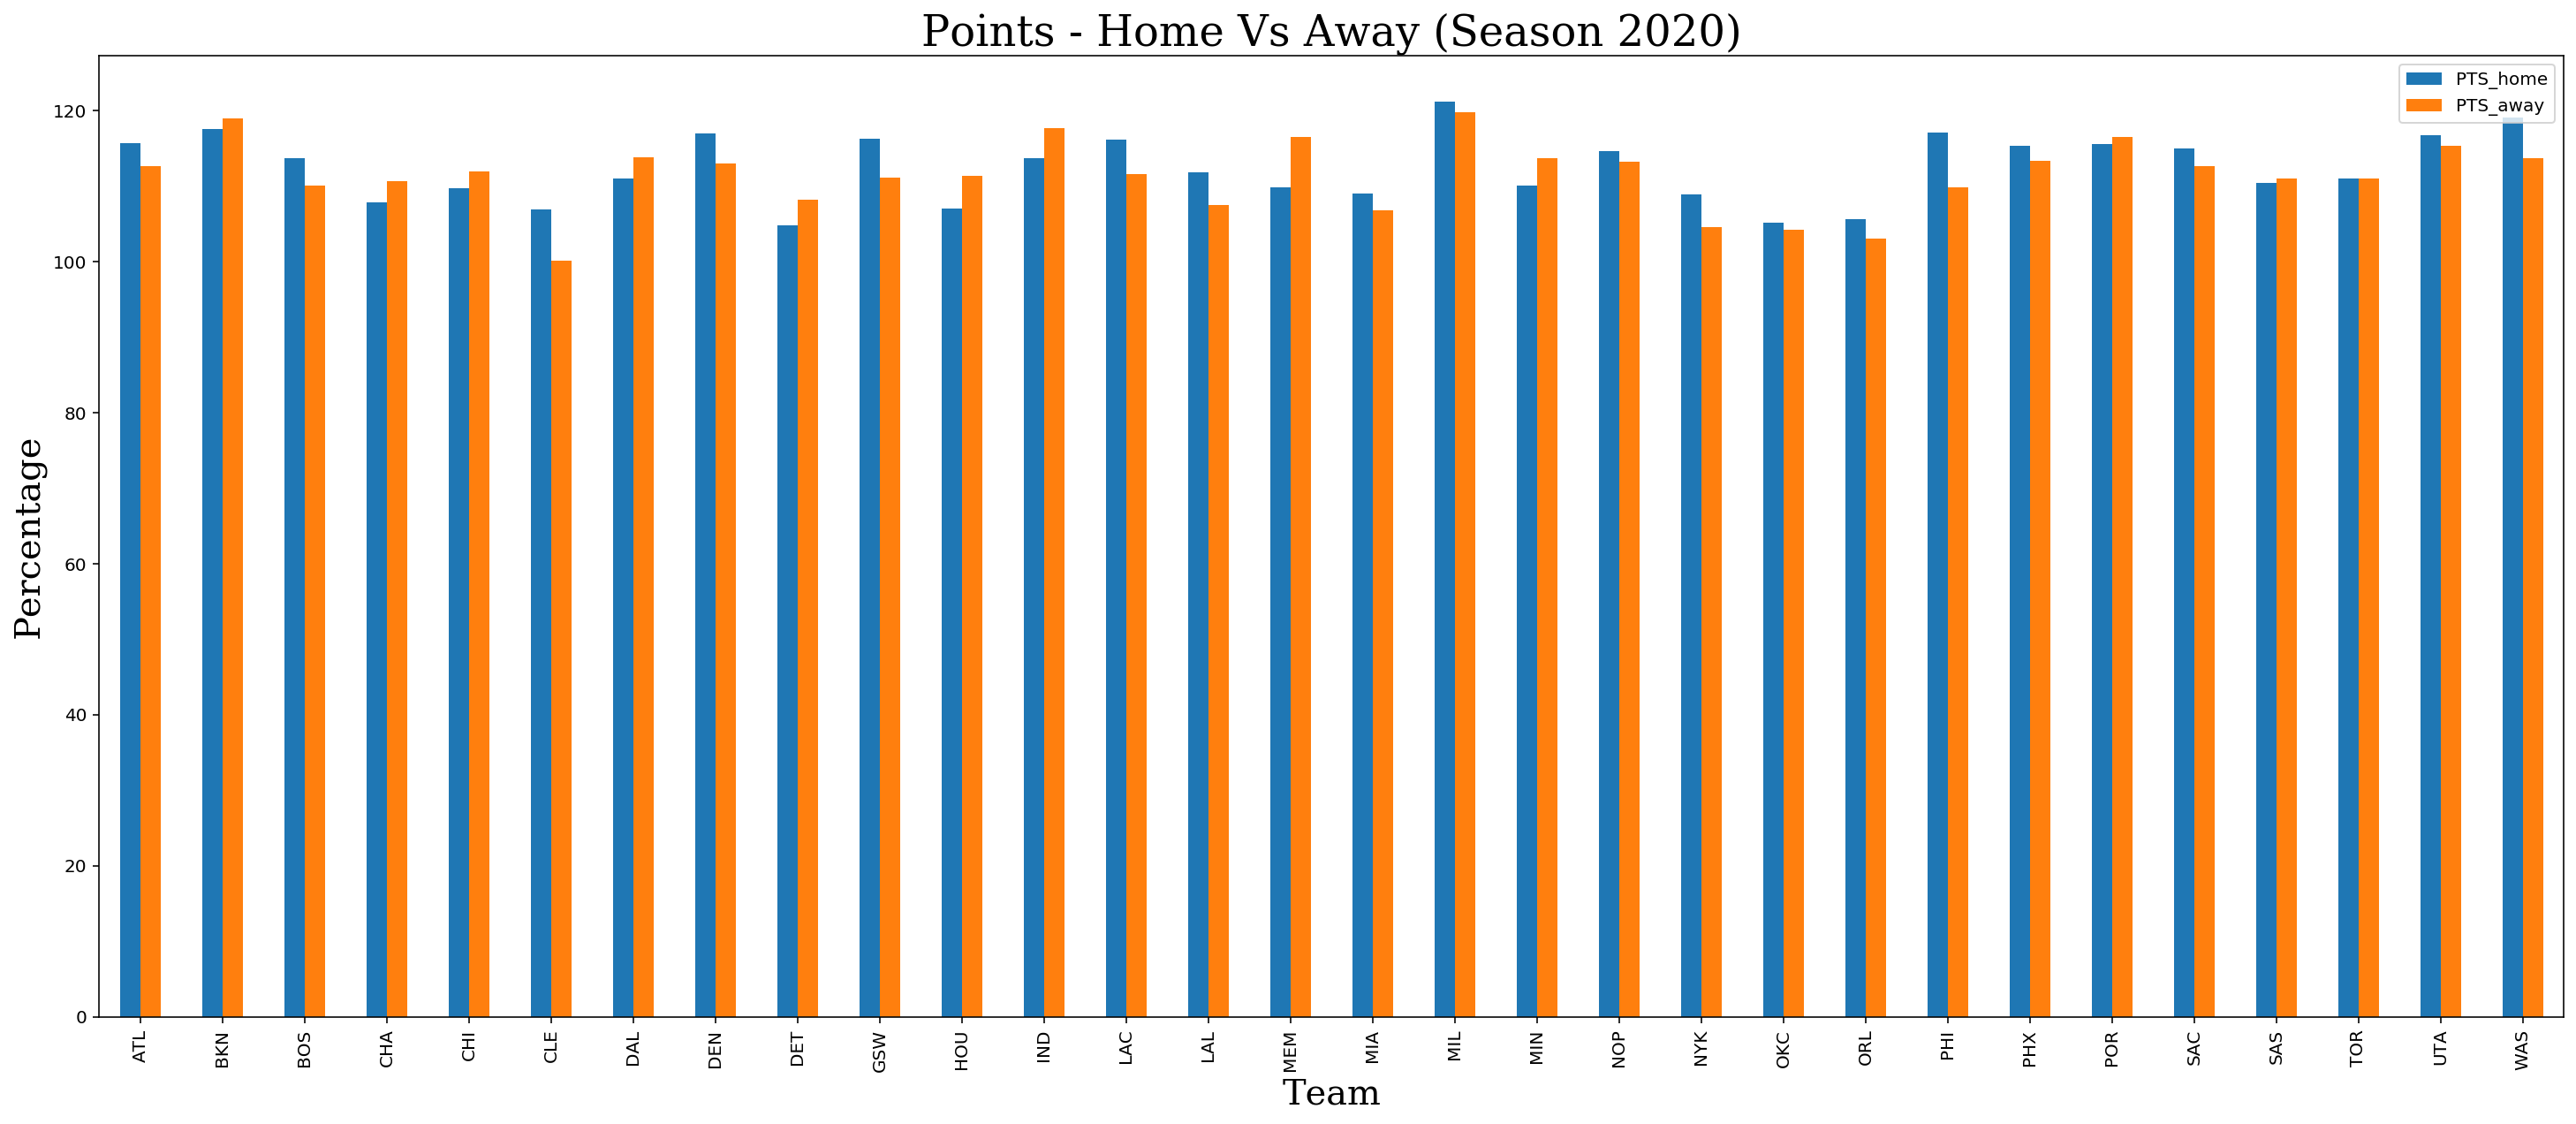

In [18]:
pts_2021 = df_home_vs_away2021[['PTS_home','PTS_away']].plot(kind = 'bar', figsize = (25,10))
legend(loc = 1)
ylabel('Percentage', fontdict = font4)
xlabel('Team', fontdict = font4)
title('Points - Home Vs Away (Season 2020)', fontdict = font3)

Text(0.5, 1.0, 'Assists - Home Vs Away (Season 2020)')

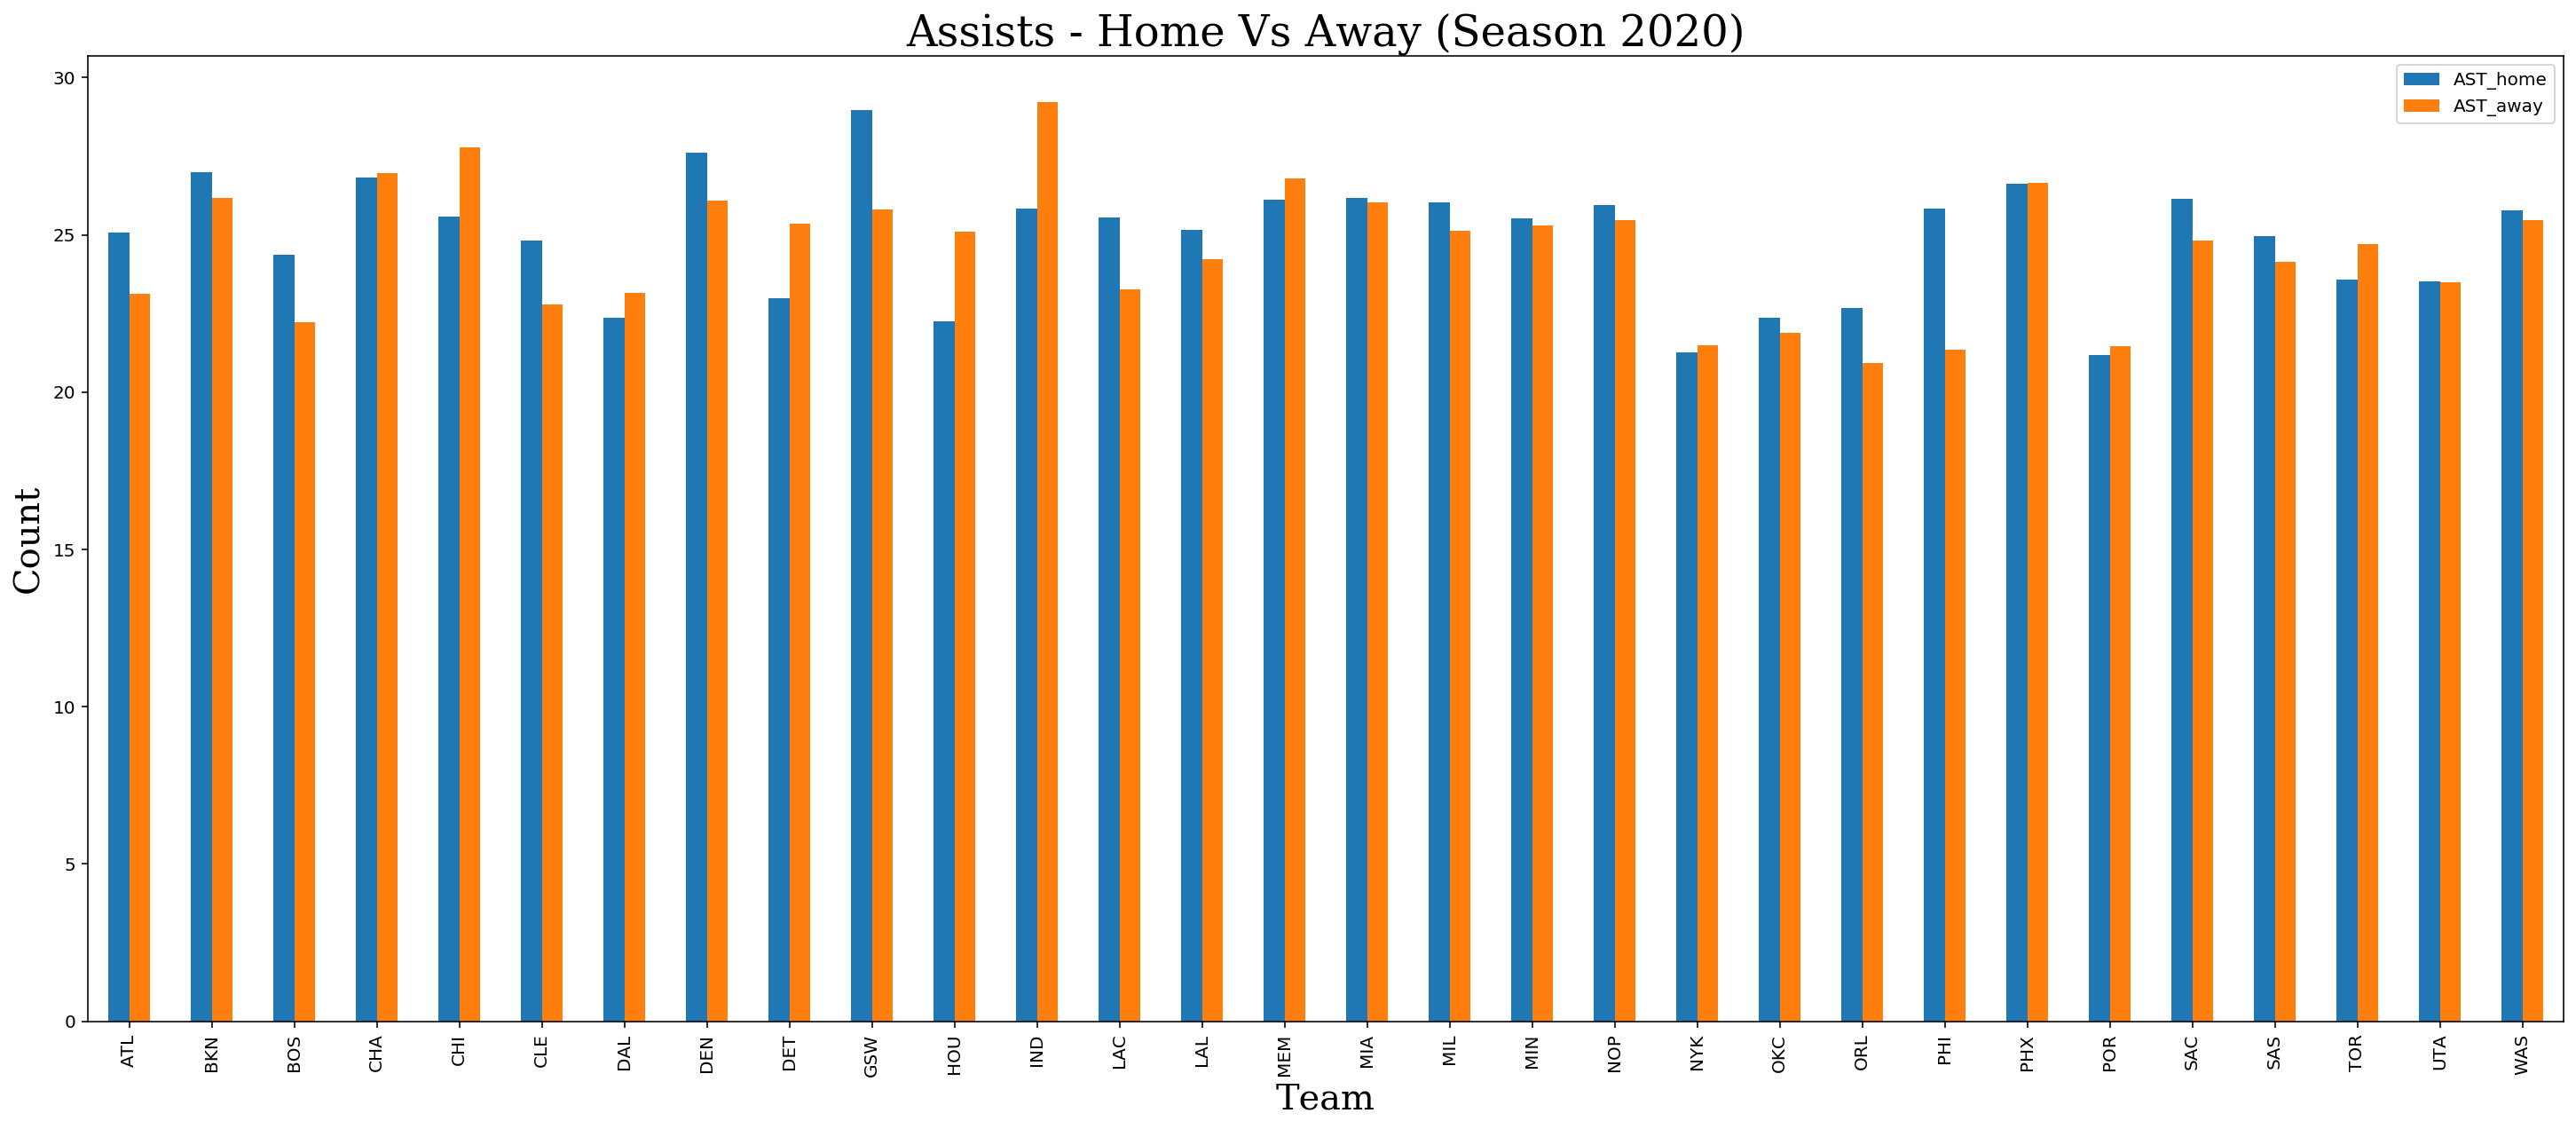

In [19]:
ast_2021 = df_home_vs_away2021[['AST_home','AST_away']].plot(kind = 'bar', figsize = (25,10))
legend(loc = 1)
ylabel('Count', fontdict = font4)
xlabel('Team', fontdict = font4)
title('Assists - Home Vs Away (Season 2020)', fontdict = font3)

Text(0.5, 1.0, 'Free Throw Percentage - Home Vs Away (Season 2020)')

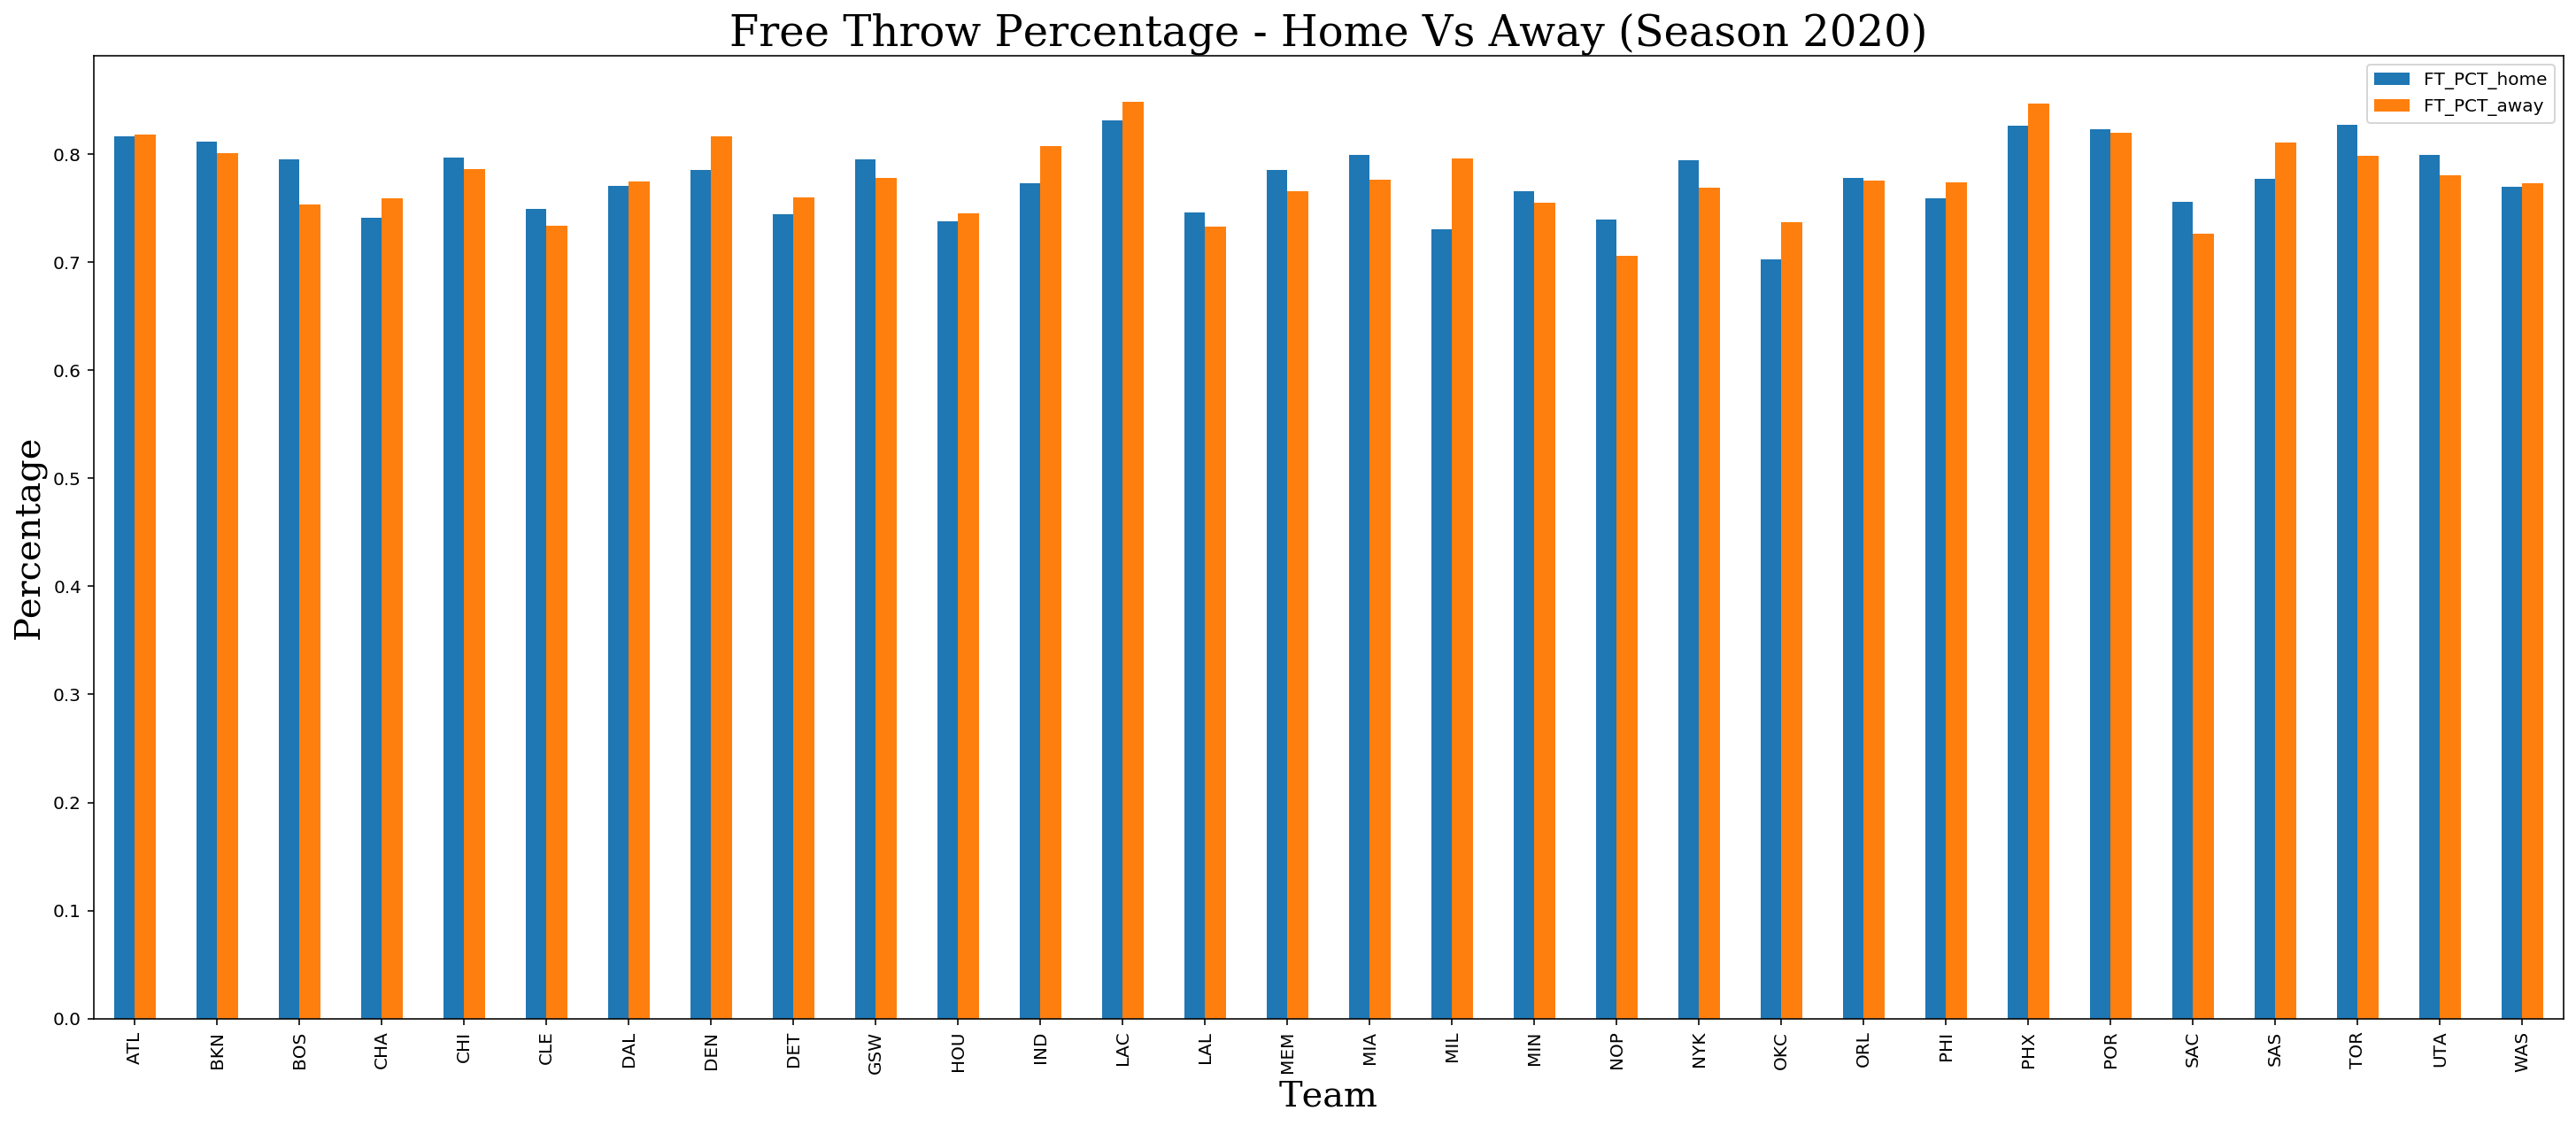

In [20]:
ft_PCT_2021 = df_home_vs_away2021[['FT_PCT_home','FT_PCT_away']].plot(kind = 'bar', figsize = (25,10))
legend(loc = 1)
ylabel('Percentage', fontdict = font4)
xlabel('Team', fontdict = font4)
title('Free Throw Percentage - Home Vs Away (Season 2020)', fontdict = font3)

Text(0.5, 1.0, 'Rebounds - Home Vs Away (Season 2020)')

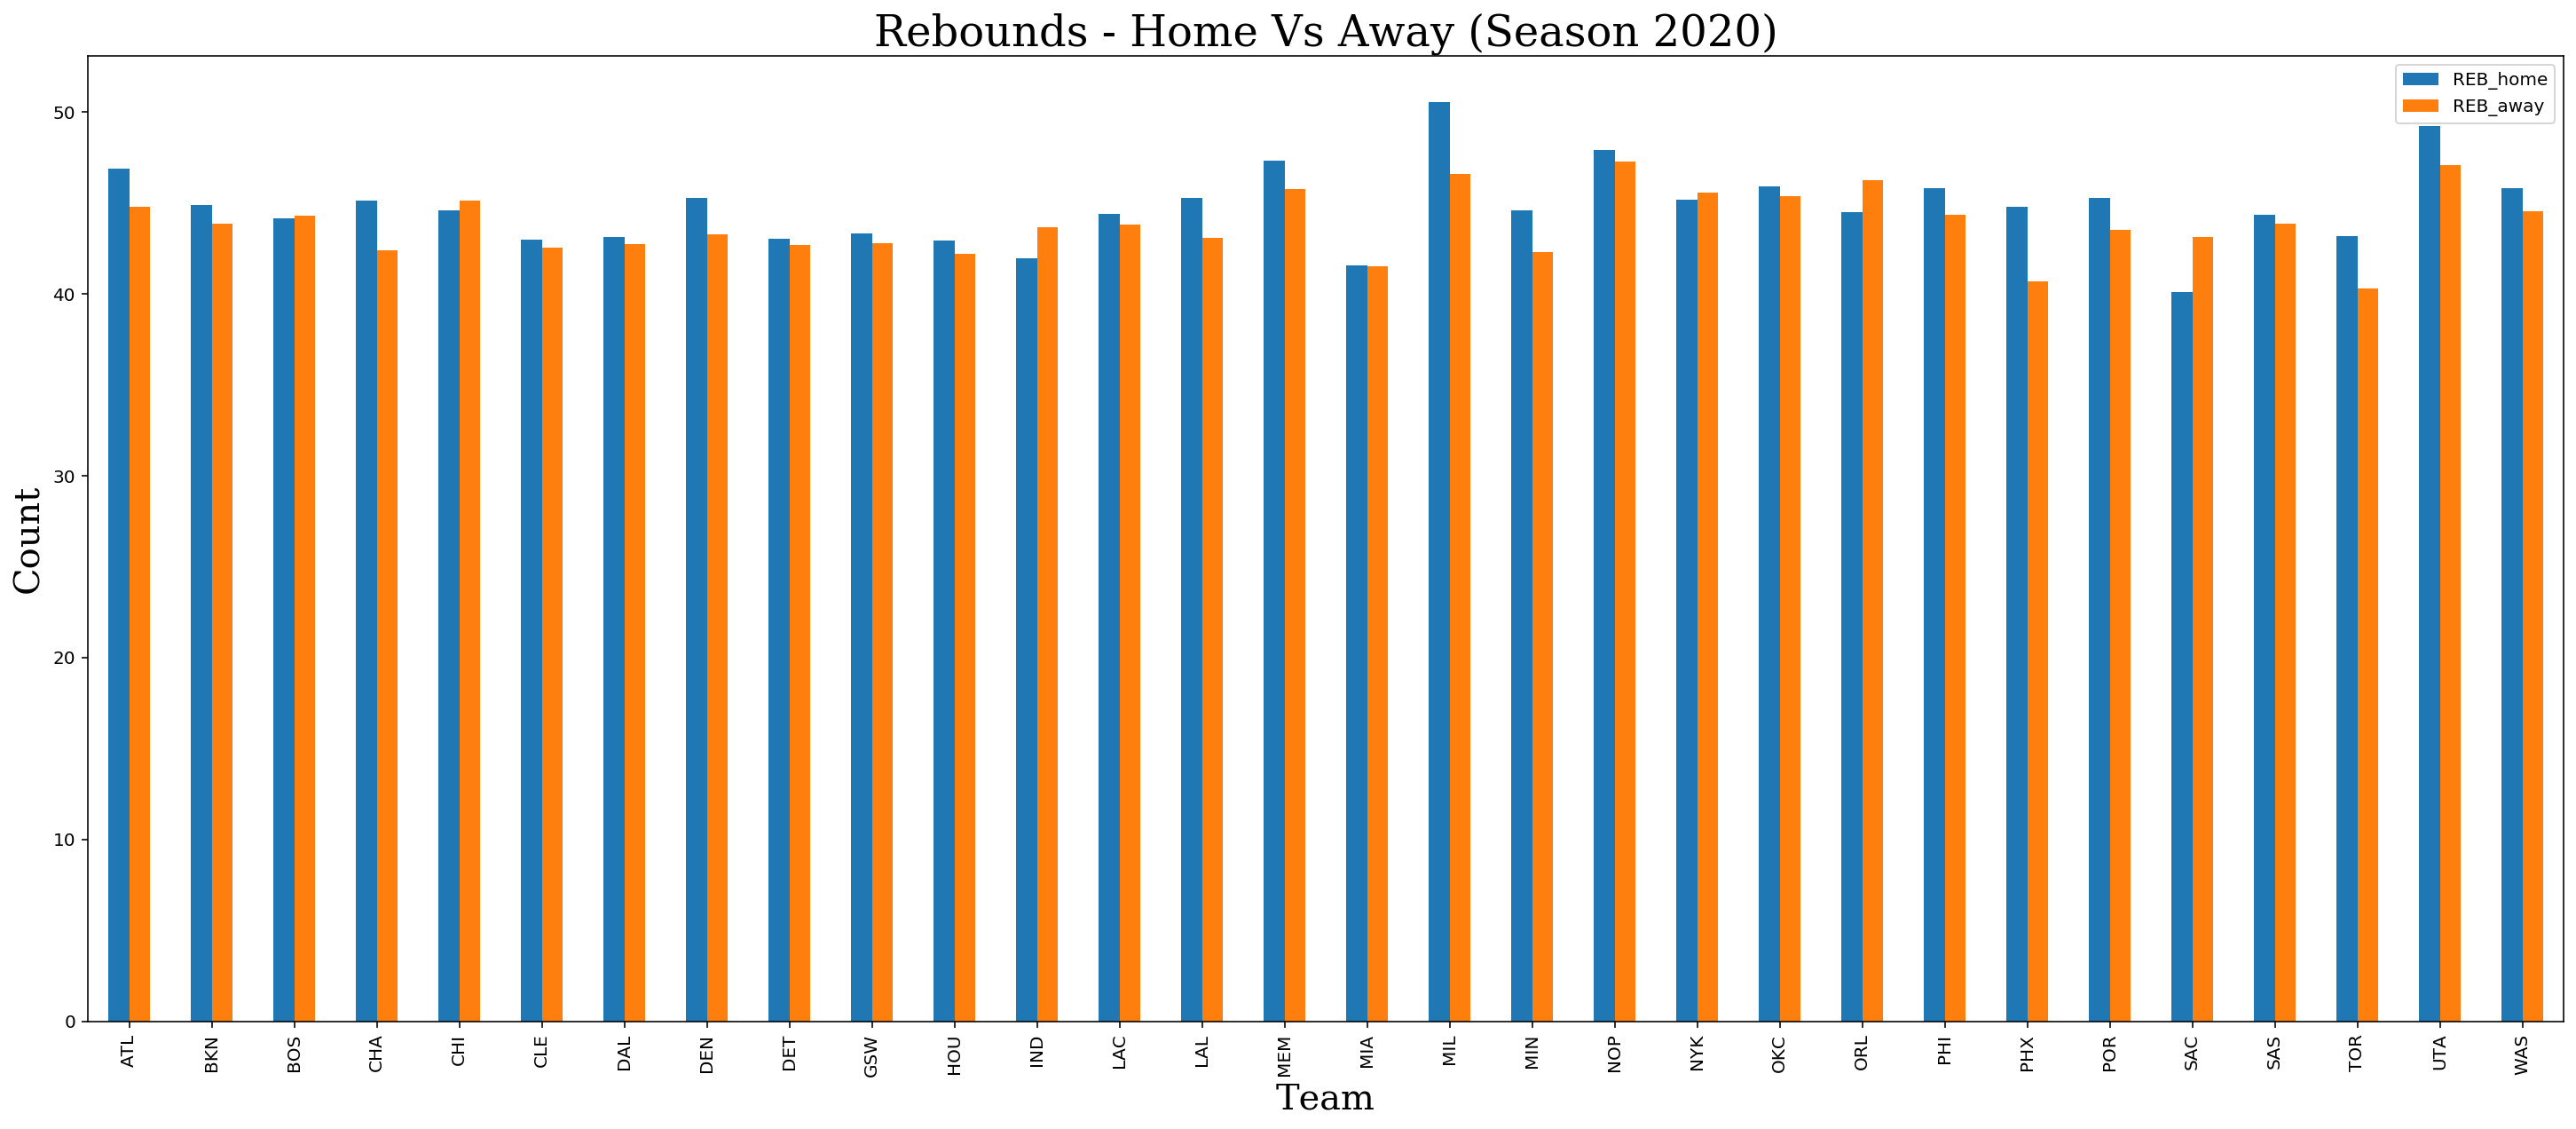

In [21]:
reb_2021 = df_home_vs_away2021[['REB_home','REB_away']].plot(kind = 'bar', figsize = (25,10))
legend(loc = 1)
ylabel('Count', fontdict = font4)
xlabel('Team', fontdict = font4)
title('Rebounds - Home Vs Away (Season 2020)', fontdict = font3)

Text(0.5, 1.0, 'Field Goal 3 Percentage - Home Vs Away (Season 2020)')

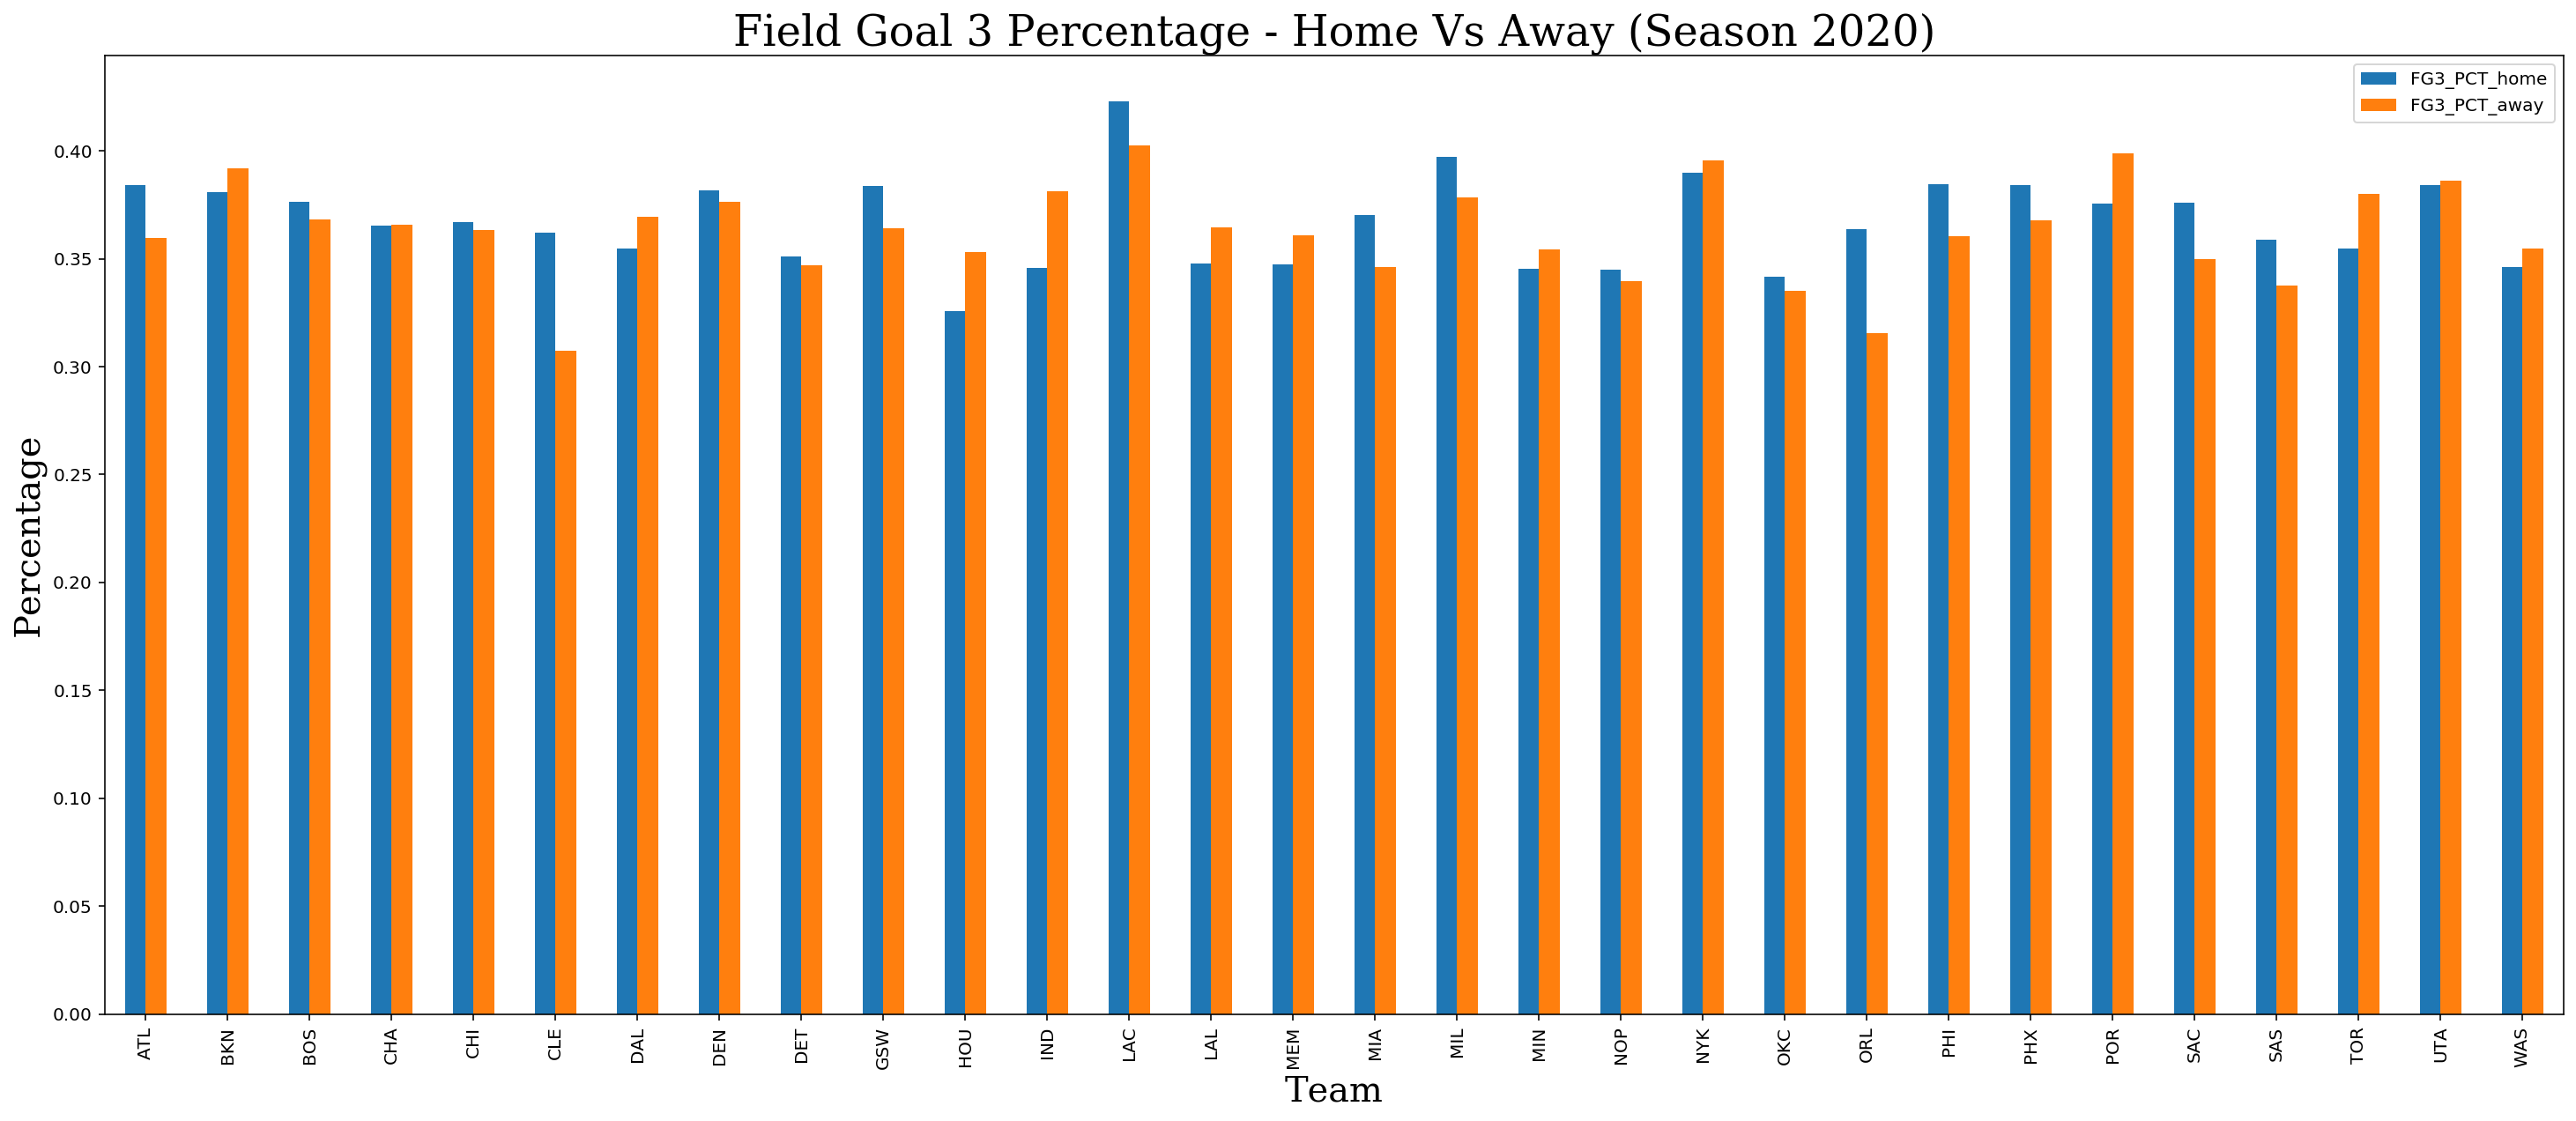

In [22]:
FG3_PCT_2021 = df_home_vs_away2021[['FG3_PCT_home','FG3_PCT_away']].plot(kind = 'bar', figsize = (25,10))
legend(loc = 1)
ylabel('Percentage', fontdict = font4)
xlabel('Team', fontdict = font4)
title('Field Goal 3 Percentage - Home Vs Away (Season 2020)', fontdict = font3)

Text(0.5, 1.0, 'Field Goal Percentage - Home Vs Away (Season 2020)')

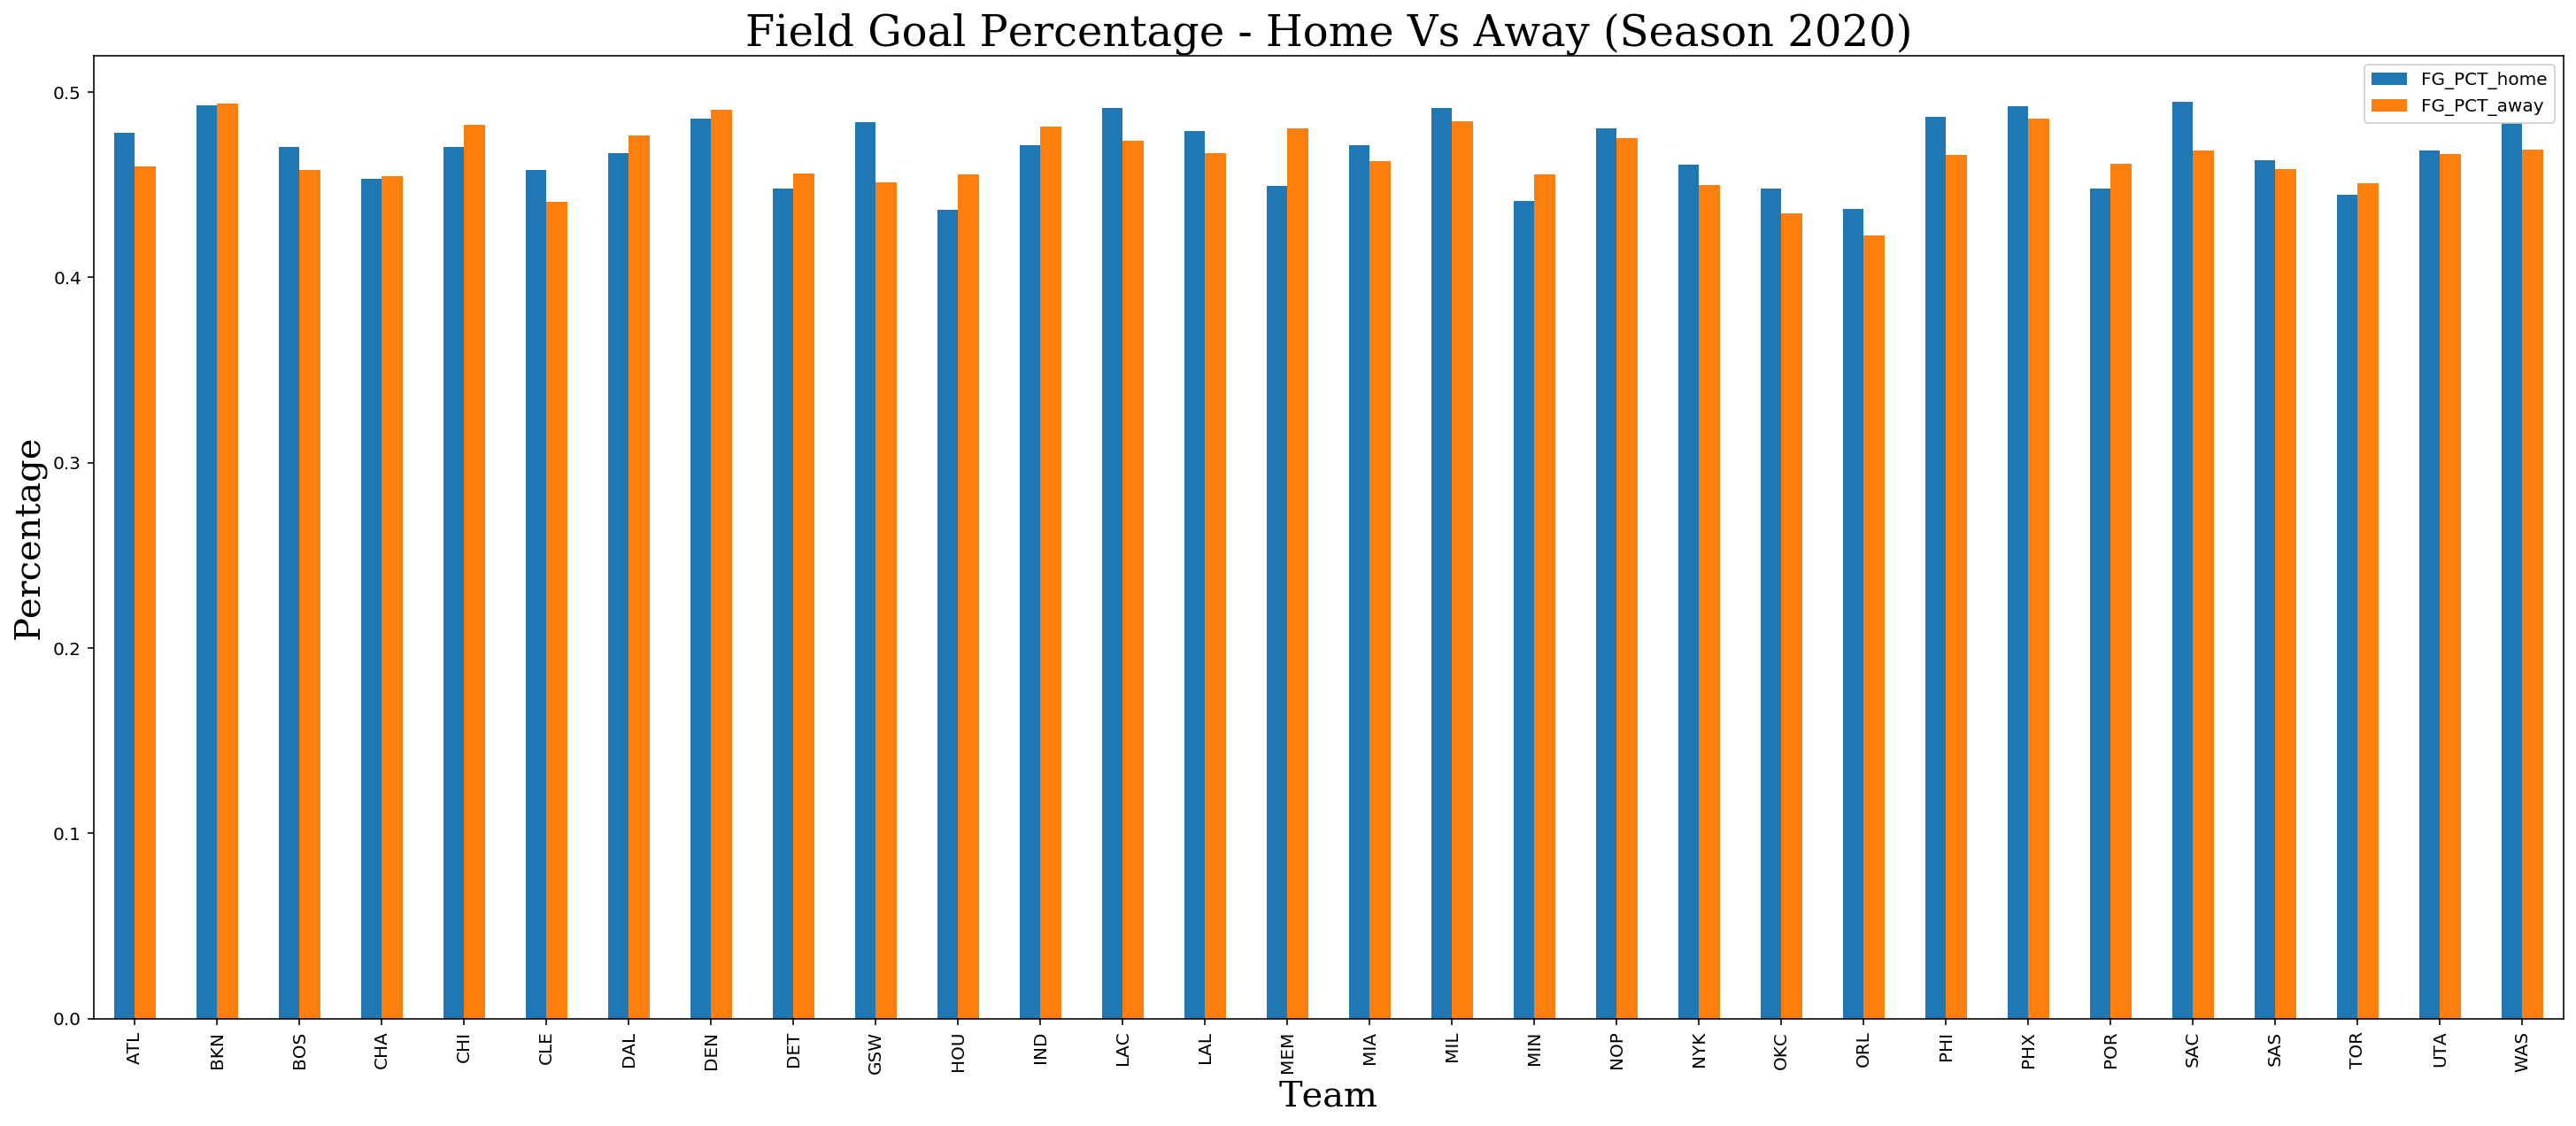

In [23]:
FG_PCT_2021 = df_home_vs_away2021[['FG_PCT_home','FG_PCT_away']].plot(kind = 'bar', figsize = (25,10))
legend(loc = 1)
ylabel('Percentage', fontdict = font4)
xlabel('Team', fontdict = font4)
title('Field Goal Percentage - Home Vs Away (Season 2020)', fontdict = font3)

# Metrics Comparison - Individual Level

This section finds the top 20 players, determined by points scored, since 2015, and explores the difference in their performance in home vs away games. 

It then explores the home vs away differential in a second tier of players called role players.

In [24]:
df_details = df_games[["GAME_ID", 'GAME_DATE_EST', 'TEAM_ID_home', 'TEAM_ID_away']]
df_details = df_details[df_details['GAME_DATE_EST']>= '1/1/2015']
df_game_details = df_games_details.merge(df_details, on = 'GAME_ID')

In [25]:
df_player_points = df_game_details.groupby(['PLAYER_NAME', 'TEAM_ABBREVIATION']).agg({'PTS':'mean'})
df_top_20_players = df_player_points.sort_values(by = 'PTS', ascending = False)[:20]
df_top_20_players.reset_index(inplace= True)
df_top_20_players.head()

,PLAYER_NAME,TEAM_ABBREVIATION,PTS
0,James Harden,HOU,30.360806
1,Kevin Durant,BKN,27.574468
2,Kevin Durant,OKC,27.540541
3,Stephen Curry,GSW,27.346080
4,Kawhi Leonard,TOR,27.218391


In [26]:
def is_home_away(ids):
    if ids[0] == ids[1]:
        return "HOME"
    else:
        return 'AWAY'
    
def is_allstar(str):
    for i in range(len(df_top_20_players['PLAYER_NAME'])):
        if str == df_top_20_players['PLAYER_NAME'][i]:
            return 1
    return 0 


df_game_details['GAME_LOCATION'] = df_game_details[['TEAM_ID', 'TEAM_ID_home']].apply(is_home_away, axis = 1)
df_game_details['IS_ALL_STAR'] = df_game_details['PLAYER_NAME'].apply(is_allstar)

df_game_details[df_game_details['IS_ALL_STAR']==1].head()

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,START_POSITION,COMMENT,MIN,FGM,...,TO,PF,PTS,PLUS_MINUS,SECONDS_PLAYED,GAME_DATE_EST,TEAM_ID_home,TEAM_ID_away,GAME_LOCATION,IS_ALL_STAR
4,42000102,1610612764,WAS,Washington,201566,Russell Westbrook,G,NaN,29:07,2.0,...,4.0,0.0,10.0,-16.0,1747,2021-05-26,1610612755,1610612764,AWAY,1
65,42000112,1610612751,BKN,Brooklyn,201142,Kevin Durant,F,NaN,29:10,8.0,...,4.0,1.0,26.0,19.0,1750,2021-05-25,1610612751,1610612738,HOME,1
68,42000112,1610612751,BKN,Brooklyn,202681,Kyrie Irving,G,NaN,27:54,6.0,...,3.0,2.0,15.0,19.0,1674,2021-05-25,1610612751,1610612738,HOME,1
69,42000112,1610612751,BKN,Brooklyn,201935,James Harden,G,NaN,27:07,6.0,...,2.0,3.0,20.0,31.0,1627,2021-05-25,1610612751,1610612738,HOME,1
74,42000152,1610612747,LAL,Los Angeles,2544,LeBron James,F,NaN,38:54,9.0,...,1.0,3.0,23.0,14.0,2334,2021-05-25,1610612756,1610612747,AWAY,1


In [27]:
df_allstar_player_home = df_game_details[(df_game_details['IS_ALL_STAR'] == 1) & (df_game_details['GAME_LOCATION'] == 'HOME')]
df_allstar_player_away = df_game_details[(df_game_details['IS_ALL_STAR'] == 1) & (df_game_details['GAME_LOCATION'] == 'AWAY')]
df_allstar_player = df_allstar_player_home.merge(df_allstar_player_away, on ='PLAYER_NAME')
df_allstar_player.head()

,GAME_ID_x,TEAM_ID_x,TEAM_ABBREVIATION_x,TEAM_CITY_x,PLAYER_ID_x,PLAYER_NAME,START_POSITION_x,COMMENT_x,MIN_x,FGM_x,...,TO_y,PF_y,PTS_y,PLUS_MINUS_y,SECONDS_PLAYED_y,GAME_DATE_EST_y,TEAM_ID_home_y,TEAM_ID_away_y,GAME_LOCATION_y,IS_ALL_STAR_y
0,42000112,1610612751,BKN,Brooklyn,201142,Kevin Durant,F,NaN,29:10,8.0,...,2.0,2.0,21.0,7.0,1904,2021-05-11,1610612741,1610612751,AWAY,1
1,42000112,1610612751,BKN,Brooklyn,201142,Kevin Durant,F,NaN,29:10,8.0,...,5.0,1.0,33.0,1.0,2438,2021-05-08,1610612743,1610612751,AWAY,1
2,42000112,1610612751,BKN,Brooklyn,201142,Kevin Durant,F,NaN,29:10,8.0,...,2.0,4.0,20.0,-2.0,2152,2021-05-06,1610612742,1610612751,AWAY,1
3,42000112,1610612751,BKN,Brooklyn,201142,Kevin Durant,F,NaN,29:10,8.0,...,3.0,4.0,32.0,1.0,2412,2021-05-04,1610612749,1610612751,AWAY,1
4,42000112,1610612751,BKN,Brooklyn,201142,Kevin Durant,F,NaN,29:10,8.0,...,5.0,3.0,42.0,-8.0,2392,2021-05-02,1610612749,1610612751,AWAY,1


In [28]:
df_allstar = df_game_details[(df_game_details['IS_ALL_STAR'] == 1)]
df_allstar = df_allstar.groupby(['PLAYER_NAME', 'GAME_LOCATION'])['FG_PCT','FG3_PCT', 'FT_PCT', 'REB', 'AST', 'STL', 'BLK', 'TO', 'PF', 'PTS'].agg('mean')
df_allstar.reset_index(inplace = True)
df_allstar.sort_values(by = 'PTS')
df_allstar.drop(labels = [4, 5, 24, 25], inplace = True)
df_allstar.head()

,PLAYER_NAME,GAME_LOCATION,FG_PCT,FG3_PCT,FT_PCT,REB,AST,STL,BLK,TO,PF,PTS
0,Anthony Davis,AWAY,0.505970,0.230035,0.771758,10.307359,2.567100,1.363636,2.051948,2.151515,2.290043,25.467532
1,Anthony Davis,HOME,0.514502,0.237450,0.788779,10.696970,2.831169,1.432900,2.476190,2.181818,2.272727,26.636364
2,Damian Lillard,AWAY,0.425689,0.342629,0.863788,4.321555,6.310954,1.003534,0.356890,2.883392,1.978799,25.897527
3,Damian Lillard,HOME,0.439226,0.361364,0.860608,4.378092,6.943463,1.003534,0.293286,2.908127,1.731449,26.042403
6,James Harden,AWAY,0.447323,0.353631,0.861188,6.106383,8.418440,1.726950,0.599291,4.673759,2.968085,29.872340


Text(0.5, 1.0, 'All-Stars Performance - Home Vs Away')

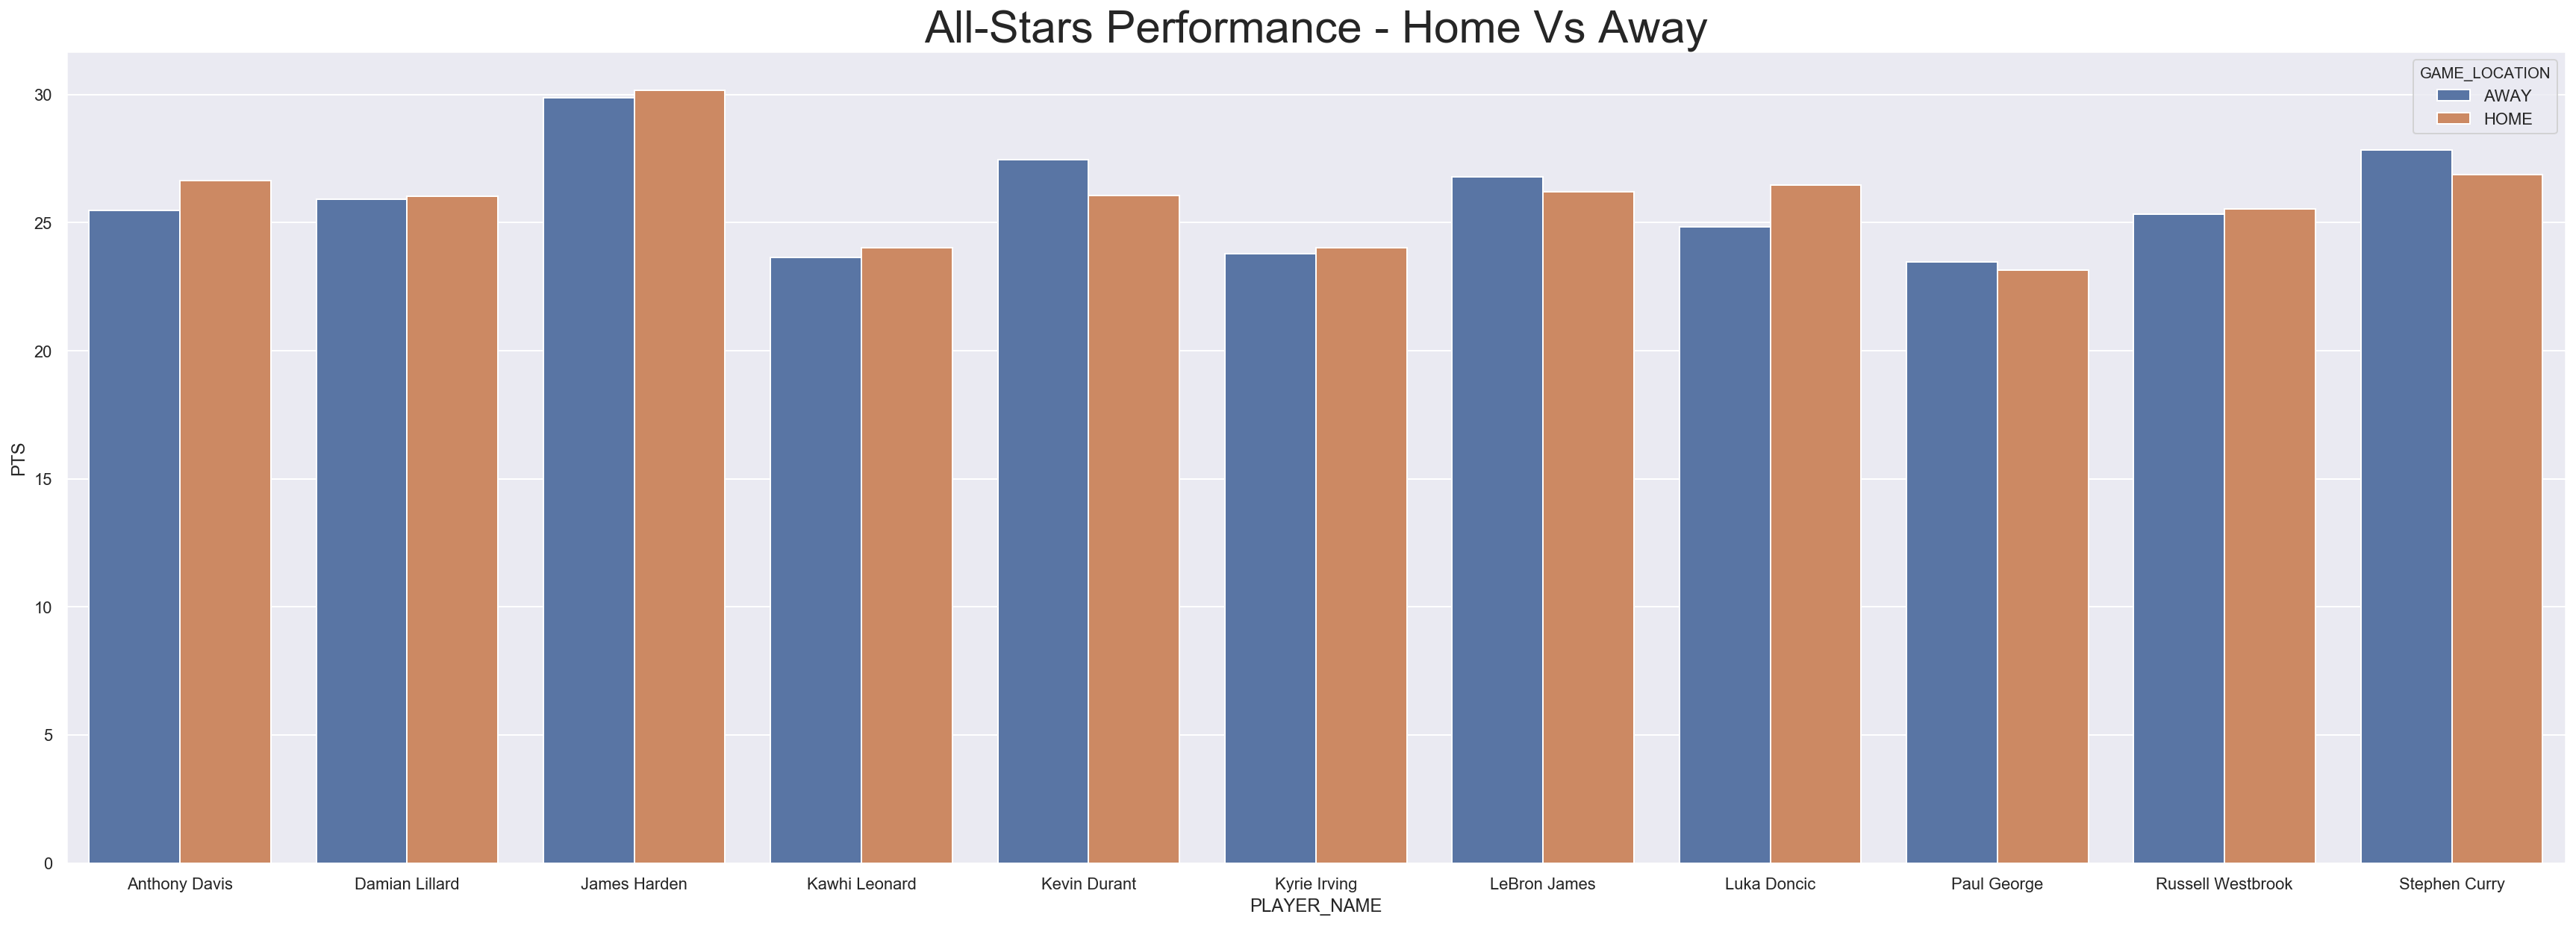

In [29]:
sn.set(rc={'figure.figsize':(30,10)})
sn.barplot(data = df_allstar, x='PLAYER_NAME' , y='PTS', hue='GAME_LOCATION', ci = None)
plt.title( "All-Stars Performance - Home Vs Away" , size = 30 )

In [30]:
#Creating a dataframe of players based on their average points per game. Sorted in a descending matter
df_ppg = df_game_details.groupby(['PLAYER_NAME', 'TEAM_ABBREVIATION', 'GAME_LOCATION']).agg({'PTS':'mean'})
df_ppg.sort_values(by = 'PTS', ascending = False, inplace = True)
df_ppg.reset_index(inplace= True)
df_ppg.drop_duplicates(subset = ['PLAYER_NAME']).head()

,PLAYER_NAME,TEAM_ABBREVIATION,GAME_LOCATION,PTS
0,James Harden,HOU,HOME,30.718861
2,Kevin Durant,BKN,AWAY,29.555556
4,Stephen Curry,GSW,AWAY,27.844358
6,DeMarcus Cousins,SAC,HOME,27.582278
7,Kawhi Leonard,TOR,AWAY,27.578947


In [31]:
#Aggregating for players that scored between 10 and 15 points per game
df_roleplayer_points = df_ppg[(df_ppg['PTS'] > 10) & (df_ppg['PTS'] < 15)]
df_roleplayer_points.head()

,PLAYER_NAME,TEAM_ABBREVIATION,GAME_LOCATION,PTS
430,Coby White,CHI,HOME,14.961538
431,Kentavious Caldwell-Pope,DET,HOME,14.943925
432,Josh Richardson,PHI,AWAY,14.937500
433,Wesley Matthews,POR,HOME,14.933333
434,Jahlil Okafor,PHI,AWAY,14.929825


In [32]:
#Taking a random sample from df_player_points
df_role_player_sample = df_roleplayer_points.sample(n=15, replace = False)
df_role_player_sample.reset_index(inplace = True)
df_role_player_sample.head()

,index,PLAYER_NAME,TEAM_ABBREVIATION,GAME_LOCATION,PTS
0,486,Jusuf Nurkic,POR,HOME,14.500000
1,716,Jeff Green,HOU,HOME,12.750000
2,932,Jordan Hamilton,NOP,HOME,11.666667
3,667,Trevor Ariza,POR,HOME,13.083333
4,606,De'Andre Hunter,ATL,HOME,13.510638


In [33]:
#applying function on to game details dataframe to create a new column that shows whether a player is a role player based 
#on the random sample above
def is_role_player(str):
        if str in df_role_player_sample['PLAYER_NAME'].values:
            return 1
        else:
            return 0 
df_game_details['IS_ROLE_PLAYER'] = df_game_details['PLAYER_NAME'].apply(is_role_player)
# df_game_details['IS_ROLE_PLAYER'] = df_game_details['PLAYER_NAME'].apply(is_role_player)
# df_game_details[df_game_details['IS_ROLE_PLAYER']==1]
df_role_players = df_game_details[df_game_details['IS_ROLE_PLAYER']==1]
df_role_players.head()

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,START_POSITION,COMMENT,MIN,FGM,...,PF,PTS,PLUS_MINUS,SECONDS_PLAYED,GAME_DATE_EST,TEAM_ID_home,TEAM_ID_away,GAME_LOCATION,IS_ALL_STAR,IS_ROLE_PLAYER
21,42000132,1610612737,ATL,Atlanta,1629631,De'Andre Hunter,F,NaN,31:59,3.0,...,4.0,18.0,5.0,1919,2021-05-26,1610612752,1610612737,AWAY,0,1
29,42000132,1610612752,NYK,New York,203493,Reggie Bullock,F,NaN,31:25,5.0,...,3.0,15.0,13.0,1885,2021-05-26,1610612752,1610612737,HOME,0,1
71,42000112,1610612751,BKN,Brooklyn,201145,Jeff Green,NaN,NaN,12:07,3.0,...,0.0,6.0,8.0,727,2021-05-25,1610612751,1610612738,HOME,0,1
108,42000122,1610612748,MIA,Miami,2772,Trevor Ariza,F,NaN,18:54,0.0,...,3.0,0.0,-25.0,1134,2021-05-24,1610612749,1610612748,AWAY,0,1
124,42000122,1610612749,MIL,Milwaukee,1626171,Bobby Portis,NaN,NaN,17:59,3.0,...,2.0,11.0,18.0,1079,2021-05-24,1610612749,1610612748,HOME,0,1


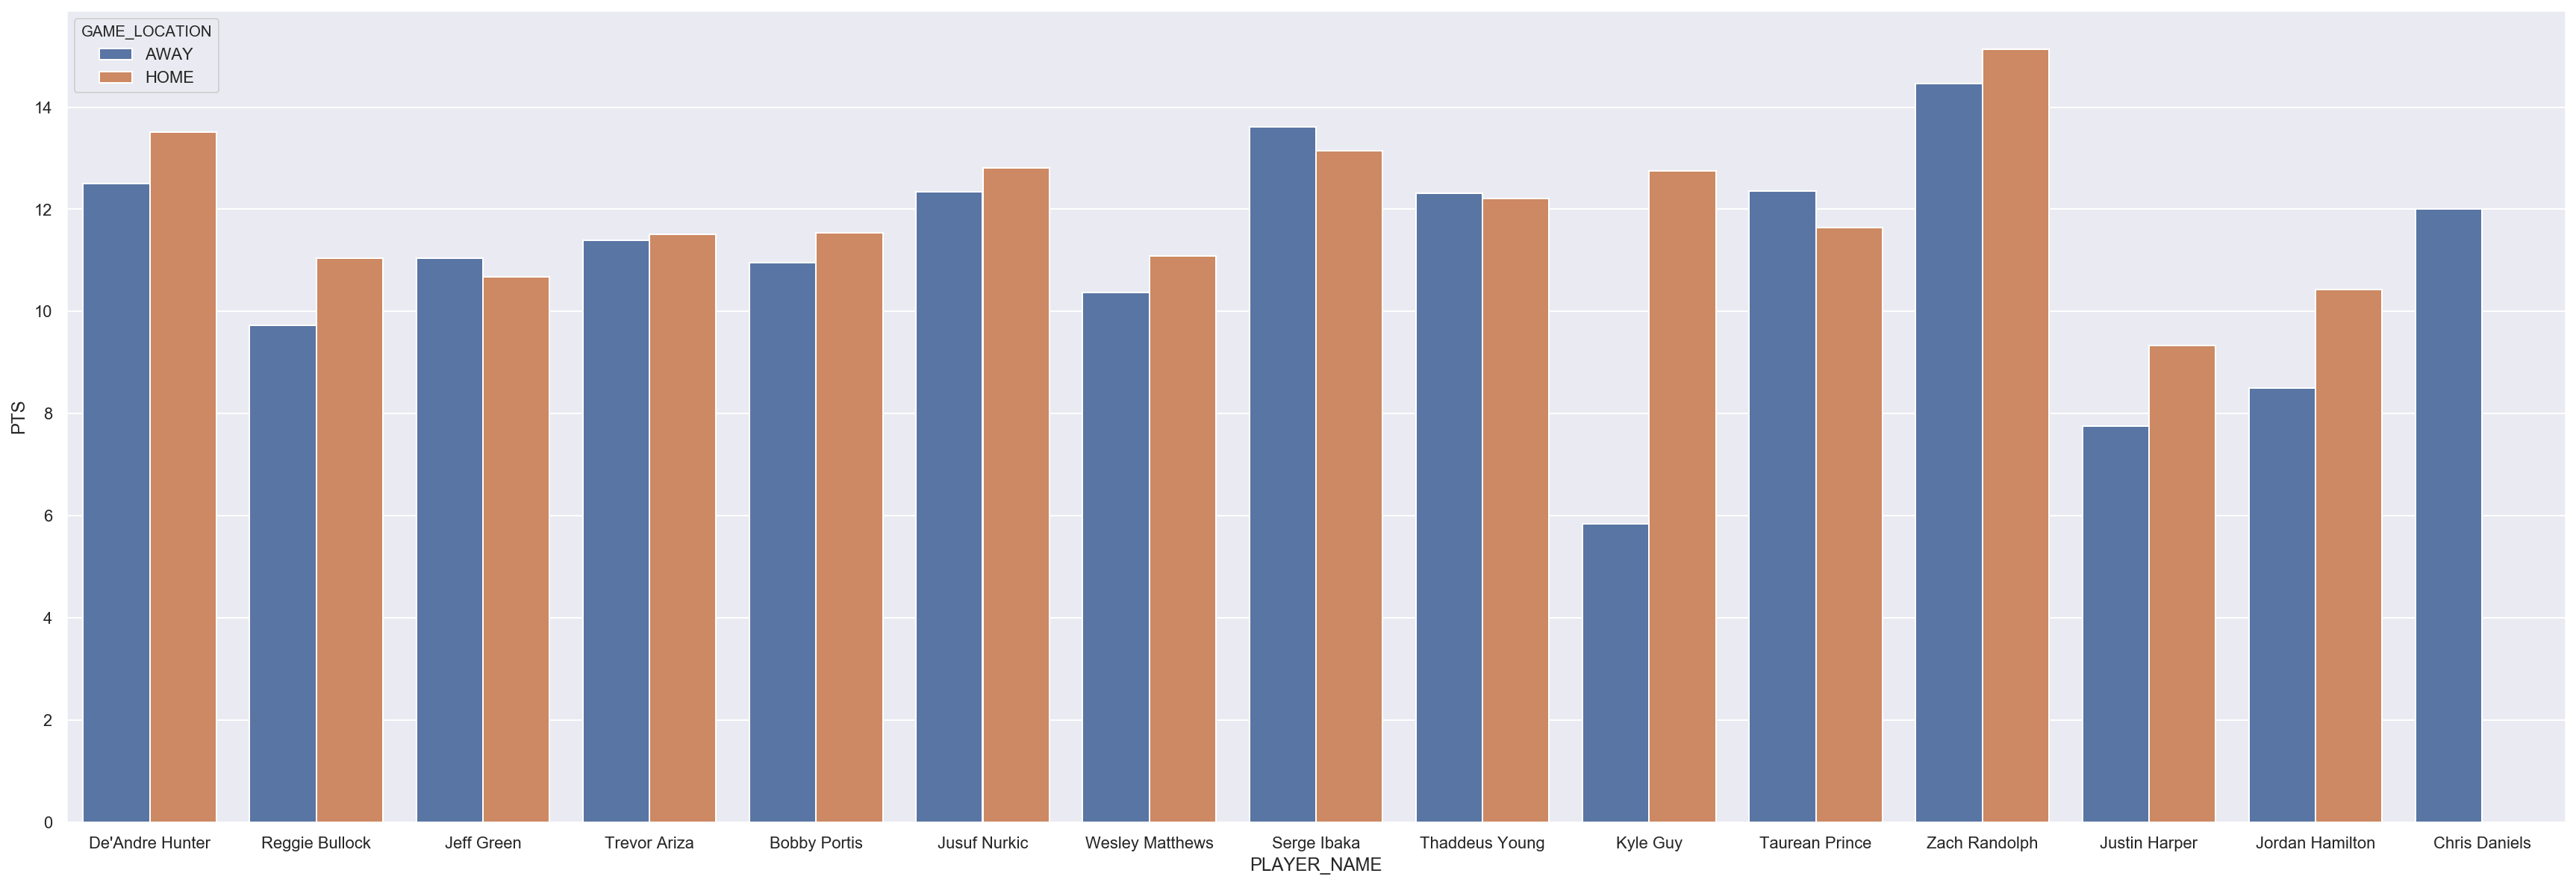

In [34]:
#graphing these players' home vs away points per game in a given year
sn.set(rc={'figure.figsize':(30,10)})
sn.barplot(data = df_role_players, x='PLAYER_NAME' , y='PTS', hue='GAME_LOCATION', ci = None)

# **Creating the dataframe for modeling**

In [35]:
df_games_home = df_games[['PTS_home', 'FG_PCT_home', 'FT_PCT_home', 'FG3_PCT_home', 'AST_home', 'REB_home', 'HOME_TEAM_WINS']]
df_games_away = df_games[['PTS_away', 'FG_PCT_away', 'FT_PCT_away', 'FG3_PCT_away', 'AST_away', 'REB_away', 'AWAY_TEAM_WINS']]

df_games_away['IS_HOME'] = 0
df_games_home['IS_HOME'] = 1

df_games_away.columns = ['PTS', 'FG_PCT', 'FT_PCT', 'FG3_PCT', 'AST', 'REB', 'WINS', 'IS_HOME']
df_games_home.columns = ['PTS', 'FG_PCT', 'FT_PCT', 'FG3_PCT', 'AST', 'REB', 'WINS', 'IS_HOME']

df_games_home_away= pd.concat([df_games_away, df_games_home])
df_games_home_away['WINS'] = pd.Categorical(df_games_home_away.WINS)
df_games_home_away['IS_HOME'] = pd.Categorical(df_games_home_away.IS_HOME)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [46]:
df_games_home_away[['PTS', 'FG_PCT', 'FT_PCT', 'FG3_PCT', 'AST', 'REB']].corr()

,PTS,FG_PCT,FT_PCT,FG3_PCT,AST,REB
PTS,1.000000,0.669358,0.192115,0.416632,0.596473,0.175082
FG_PCT,0.669358,1.000000,0.028113,0.439821,0.542201,-0.170308
FT_PCT,0.192115,0.028113,1.000000,0.029919,0.022540,-0.045773
FG3_PCT,0.416632,0.439821,0.029919,1.000000,0.336592,-0.087306
AST,0.596473,0.542201,0.022540,0.336592,1.000000,0.076021
REB,0.175082,-0.170308,-0.045773,-0.087306,0.076021,1.000000


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


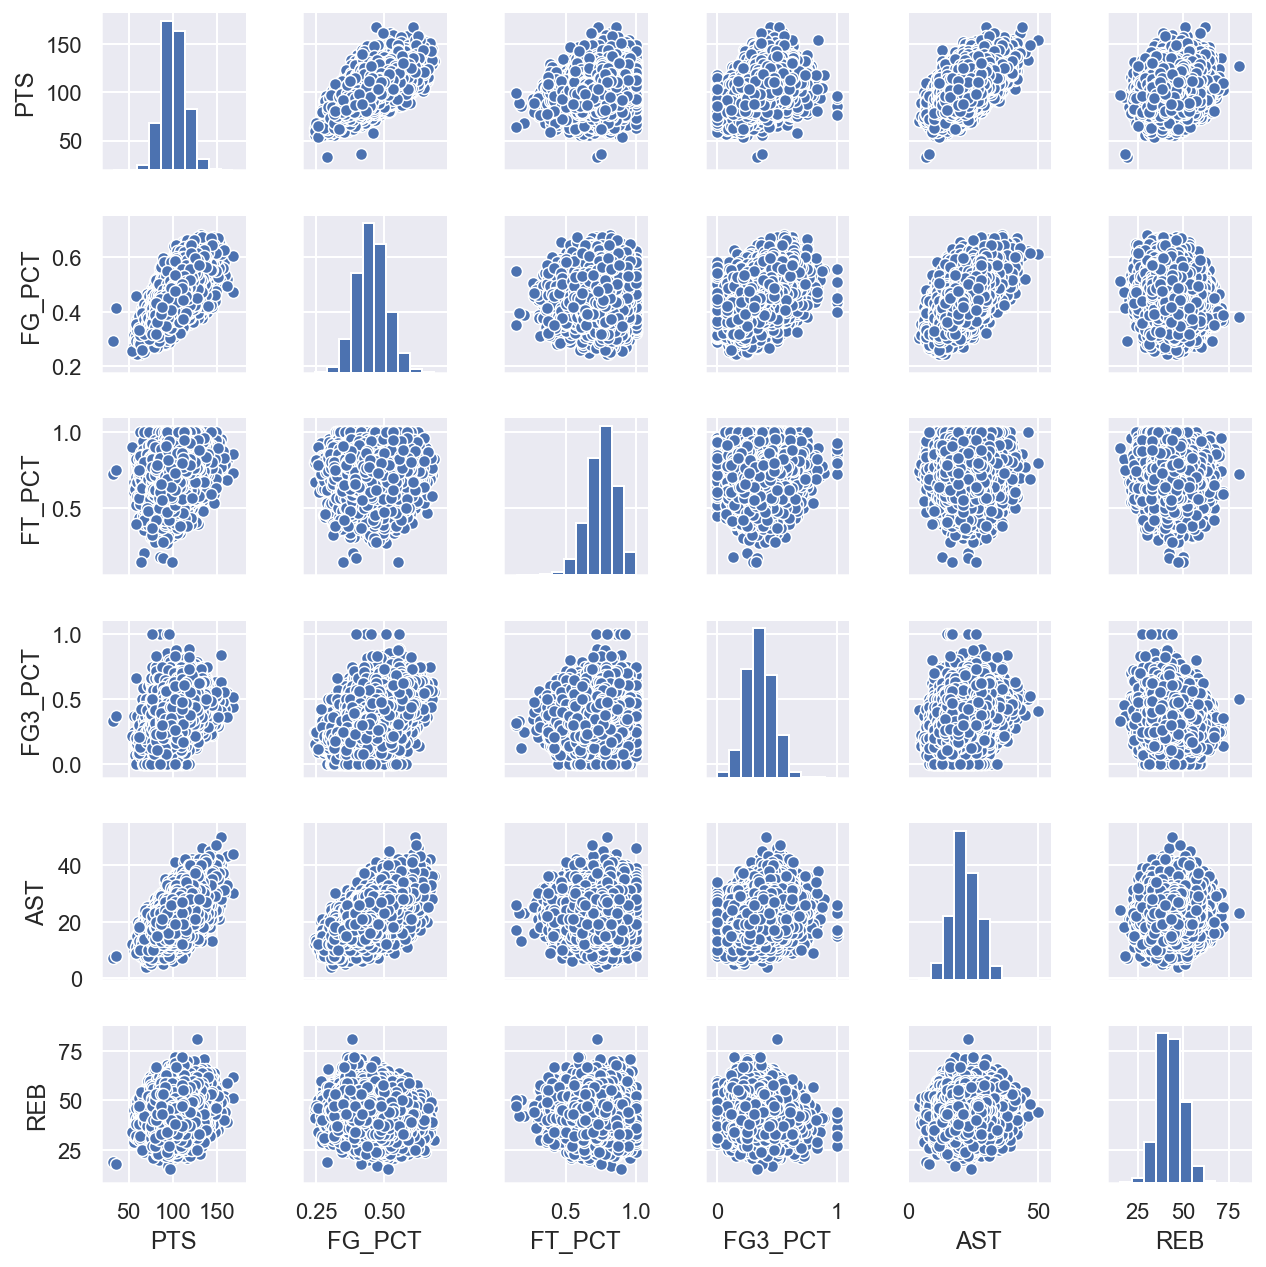

In [44]:
sn.pairplot(df_games_home_away[['PTS', 'FG_PCT', 'FT_PCT', 'FG3_PCT', 'AST', 'REB']], size = 1.5)

## Logistic Regression

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

predictors = df_games_home_away[['PTS', 'FG_PCT', 'FT_PCT', 'FG3_PCT', 'AST', 'REB', 'IS_HOME']]
y = df_games_home_away['WINS']

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(predictors, y, random_state=42, test_size=.4)

model = LogisticRegression()
model.fit(X_train, y_train)

prediction_train = model.predict(X_train)
print("Accuracy score for Random Forest on train set is", metrics.accuracy_score(y_train, prediction_train))

prediction_test = model.predict(X_test)
print("Accuracy score for Random Forest on test set is",metrics.accuracy_score(y_test, prediction_test))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy score for Random Forest on train set is 0.7638738127544098
Accuracy score for Random Forest on test set is 0.7630507784674876


In [37]:
print(confusion_matrix(y_test, prediction_test))
print(classification_report(y_test, prediction_test))

[[7503 2329]
 [2328 7494]]
              precision    recall  f1-score   support

           0       0.76      0.76      0.76      9832
           1       0.76      0.76      0.76      9822

    accuracy                           0.76     19654
   macro avg       0.76      0.76      0.76     19654
weighted avg       0.76      0.76      0.76     19654



In [38]:
pd.Series(list(model.coef_[0]), index = predictors.columns.values)

PTS         0.000184
FG_PCT     19.799854
FT_PCT      2.429479
FG3_PCT     3.553521
AST         0.012988
REB         0.142495
IS_HOME     0.583397
dtype: float64

Text(0.5, 0, 'Relative Feature Importance')

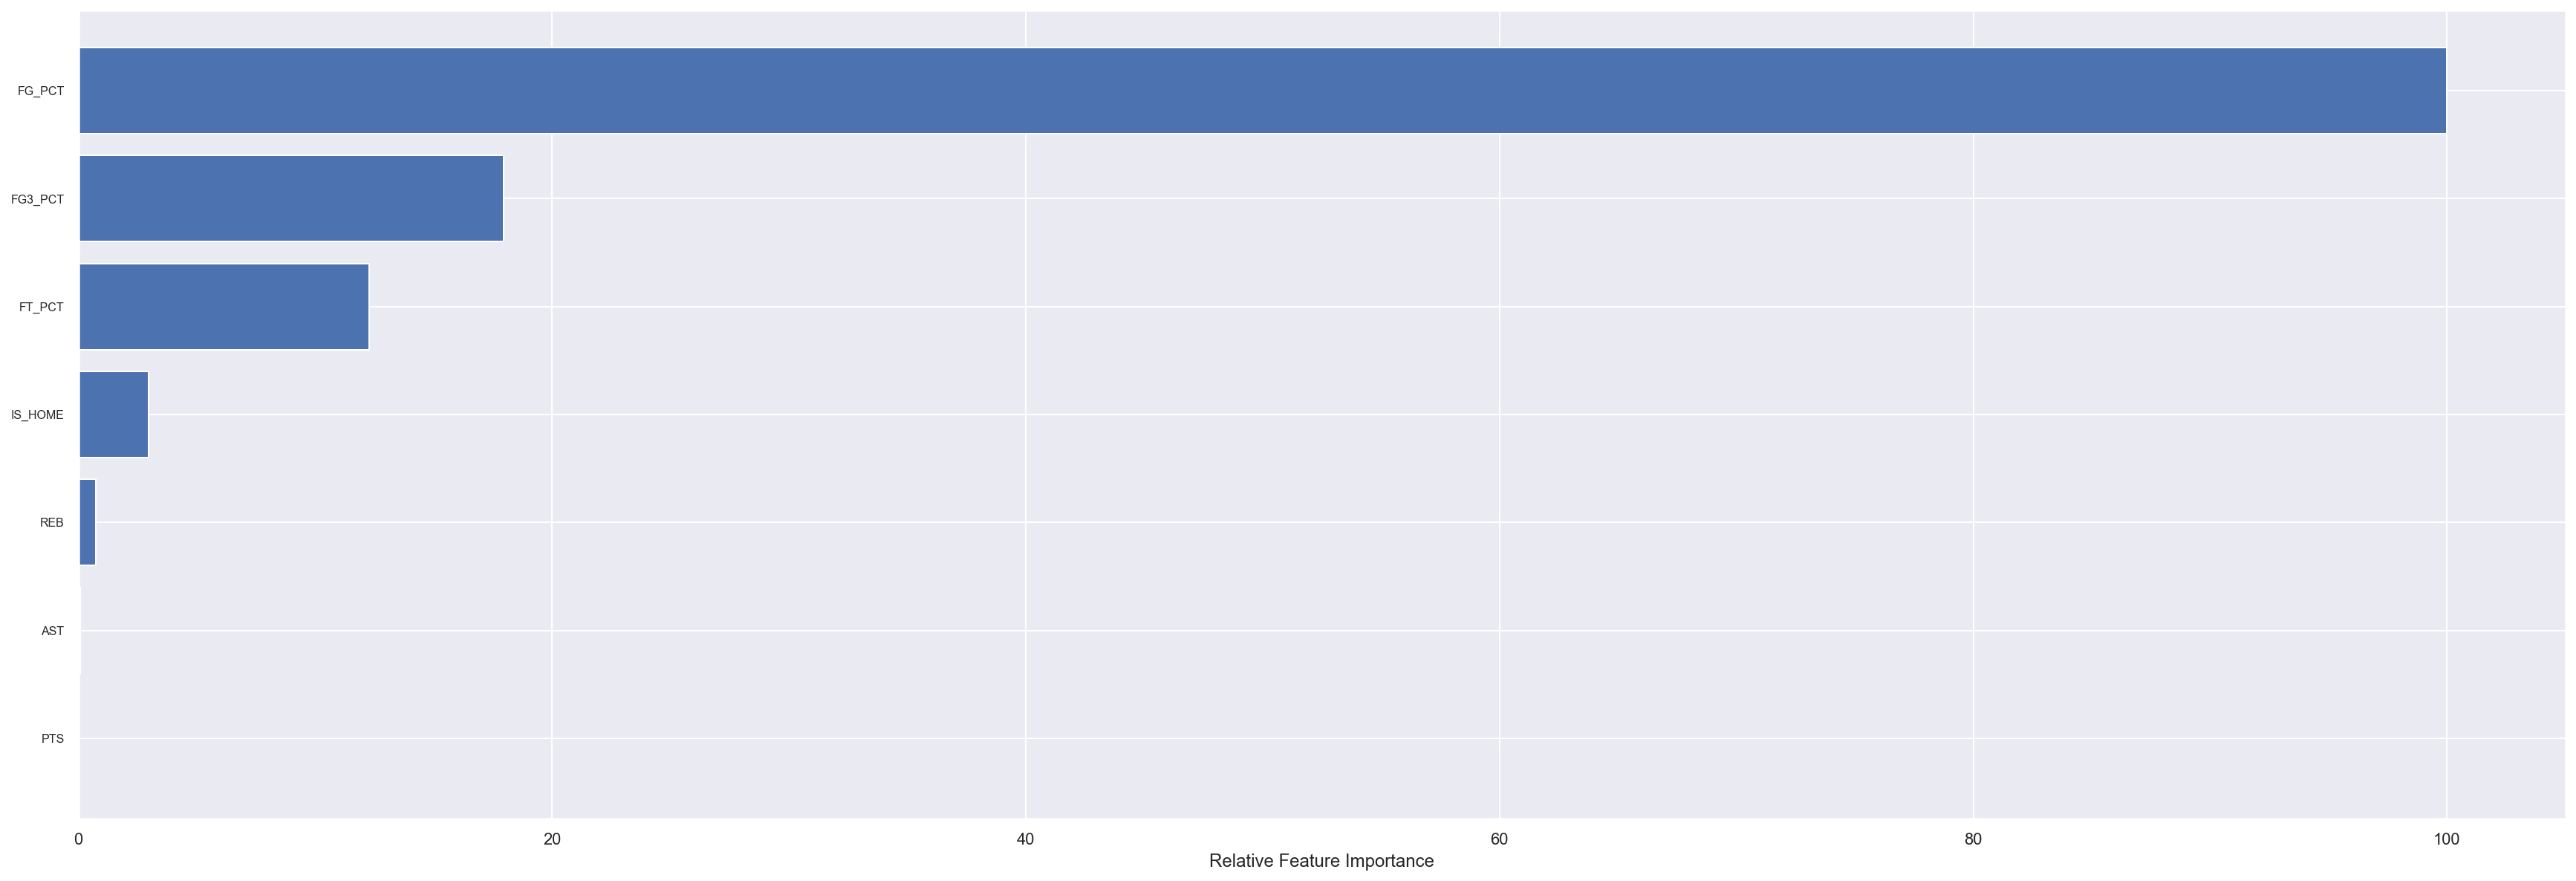

In [39]:
feature_importance = abs(model.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure()
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X_train.columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance')

## Random Forest

In [40]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

# Define the dictionary 'params_rf'
params_rf = {'n_estimators':[100, 350, 500], 'max_features':['log2', 'auto', 'sqrt'], 'min_samples_leaf':[2,10,30]}

# Instantiate grid_rf
grid_rf = GridSearchCV(estimator=rf,
                       param_grid=params_rf,
                       scoring='accuracy',
                       cv=3,
                       n_jobs=-1)

grid_rf.fit(X_train, y_train)

# Extract the best estimator
best_model = grid_rf.best_estimator_

# Predict test set labels
y_pred = best_model.predict(X_train)
y_pred1 = best_model.predict(X_test)
print("Accuracy score for Random Forest on train set is", metrics.accuracy_score(y_train, y_pred))
print("Accuracy score for Random Forest on test set is", metrics.accuracy_score(y_test, y_pred1))

Accuracy score for Random Forest on train set is 0.8287991858887381
Accuracy score for Random Forest on test set is 0.7591838811437875


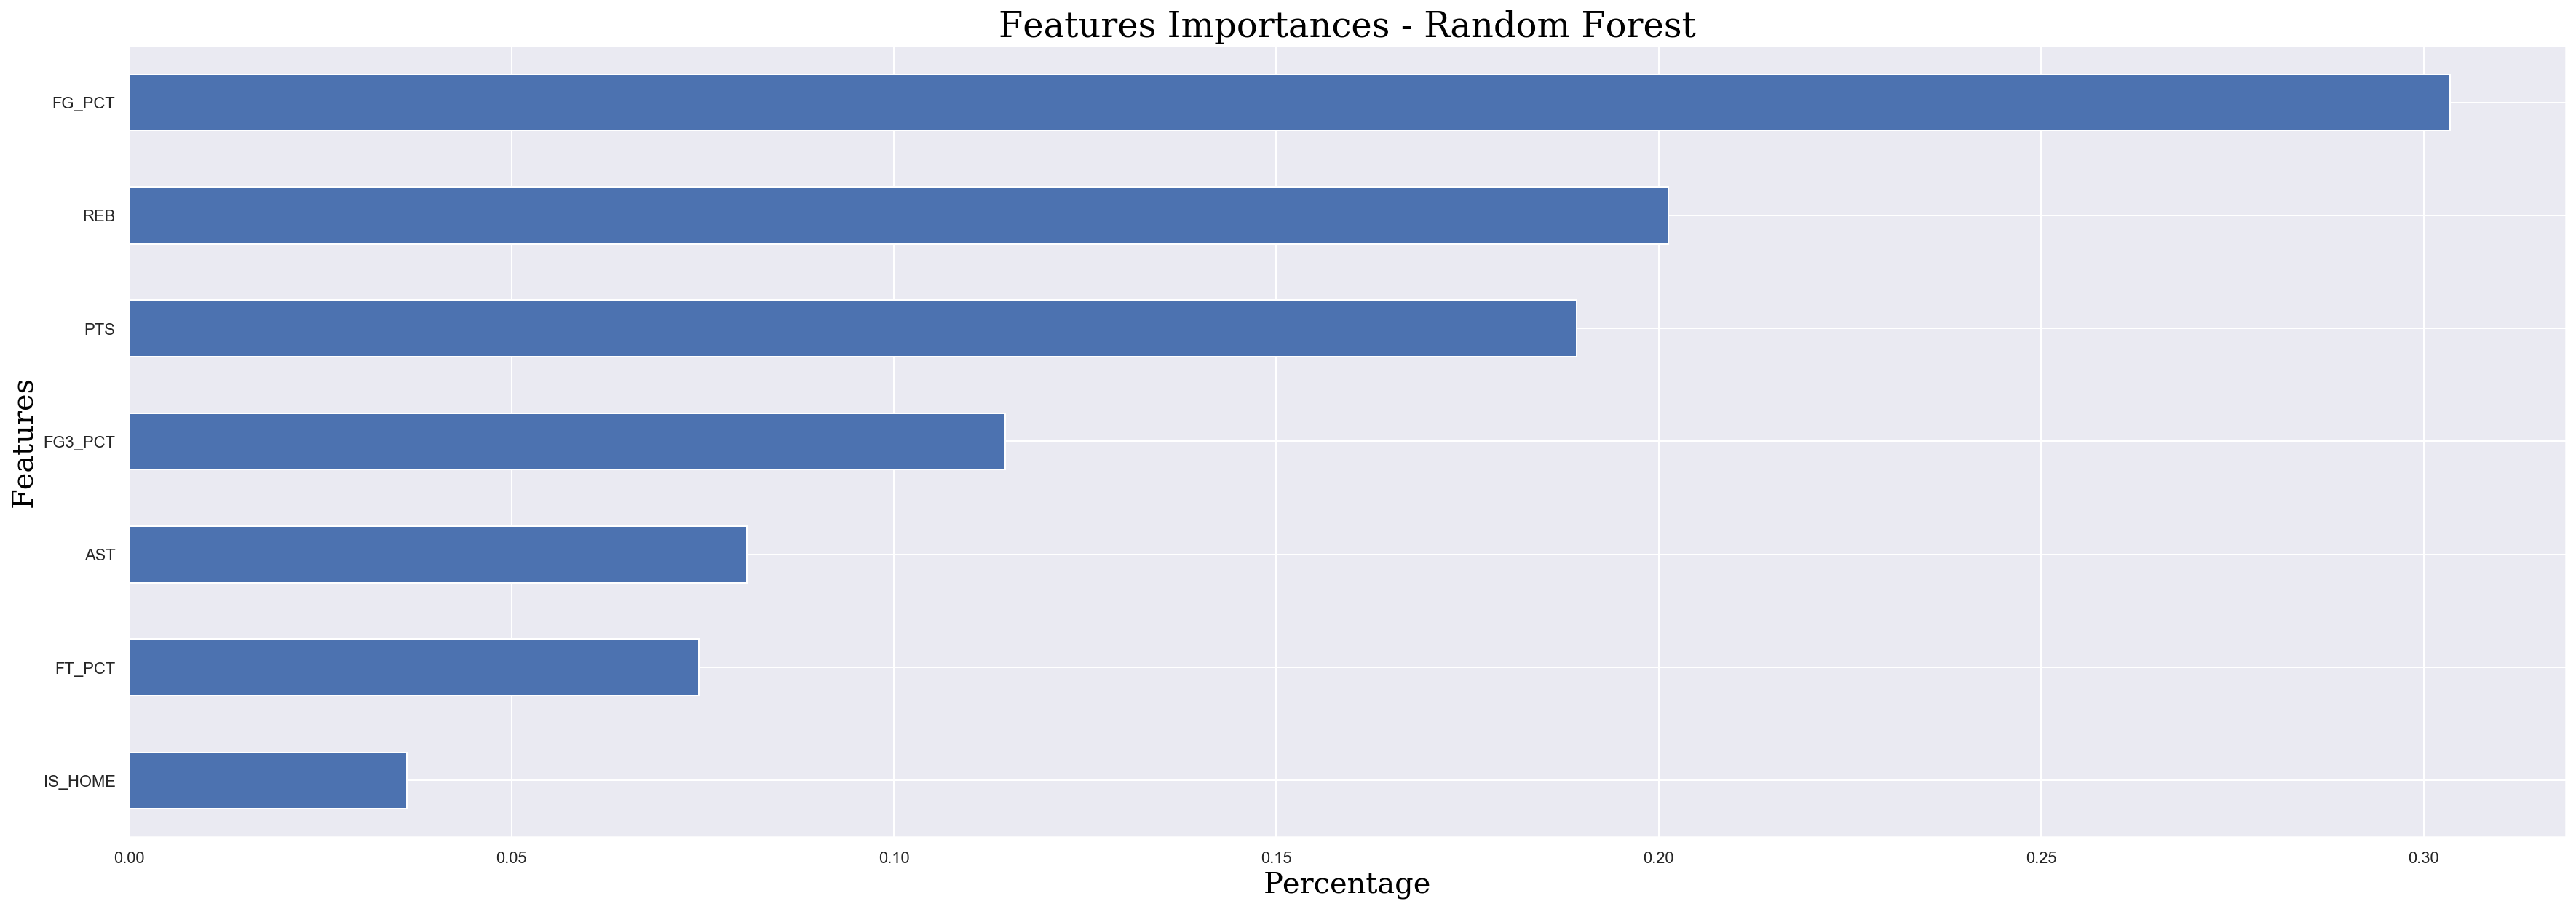

In [41]:
# Create a pd.Series of features importances
importances = pd.Series(data=best_model.feature_importances_,
                        index= X_train.columns)

# Sort importances
importances_sorted = importances.sort_values()

# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh')
plt.title('Features Importances - Random Forest', fontdict = font3)
plt.ylabel('Features', fontdict = font4)
plt.xlabel('Percentage', fontdict = font4)
plt.show()

## Gradient Boosting

In [42]:
from sklearn.metrics import mean_squared_error as MSE
from sklearn.ensemble import GradientBoostingClassifier

# Instantiate gb
gb = GradientBoostingClassifier(n_estimators=200, 
            max_depth=4,
            random_state=2)

# Fit gb to the training set
gb.fit(X_train, y_train)

# Predict test set labels
y_pred = gb.predict(X_test)
y_pred1 = gb.predict(X_train)
print("Accuracy score for Gradient Boosting on train set is", metrics.accuracy_score(y_train, y_pred1))
print("Accuracy score for Gradient Boosting on test set is", metrics.accuracy_score(y_test, y_pred))

Accuracy score for Gradient Boosting on train set is 0.7856173677069199
Accuracy score for Gradient Boosting on test set is 0.7634069400630915


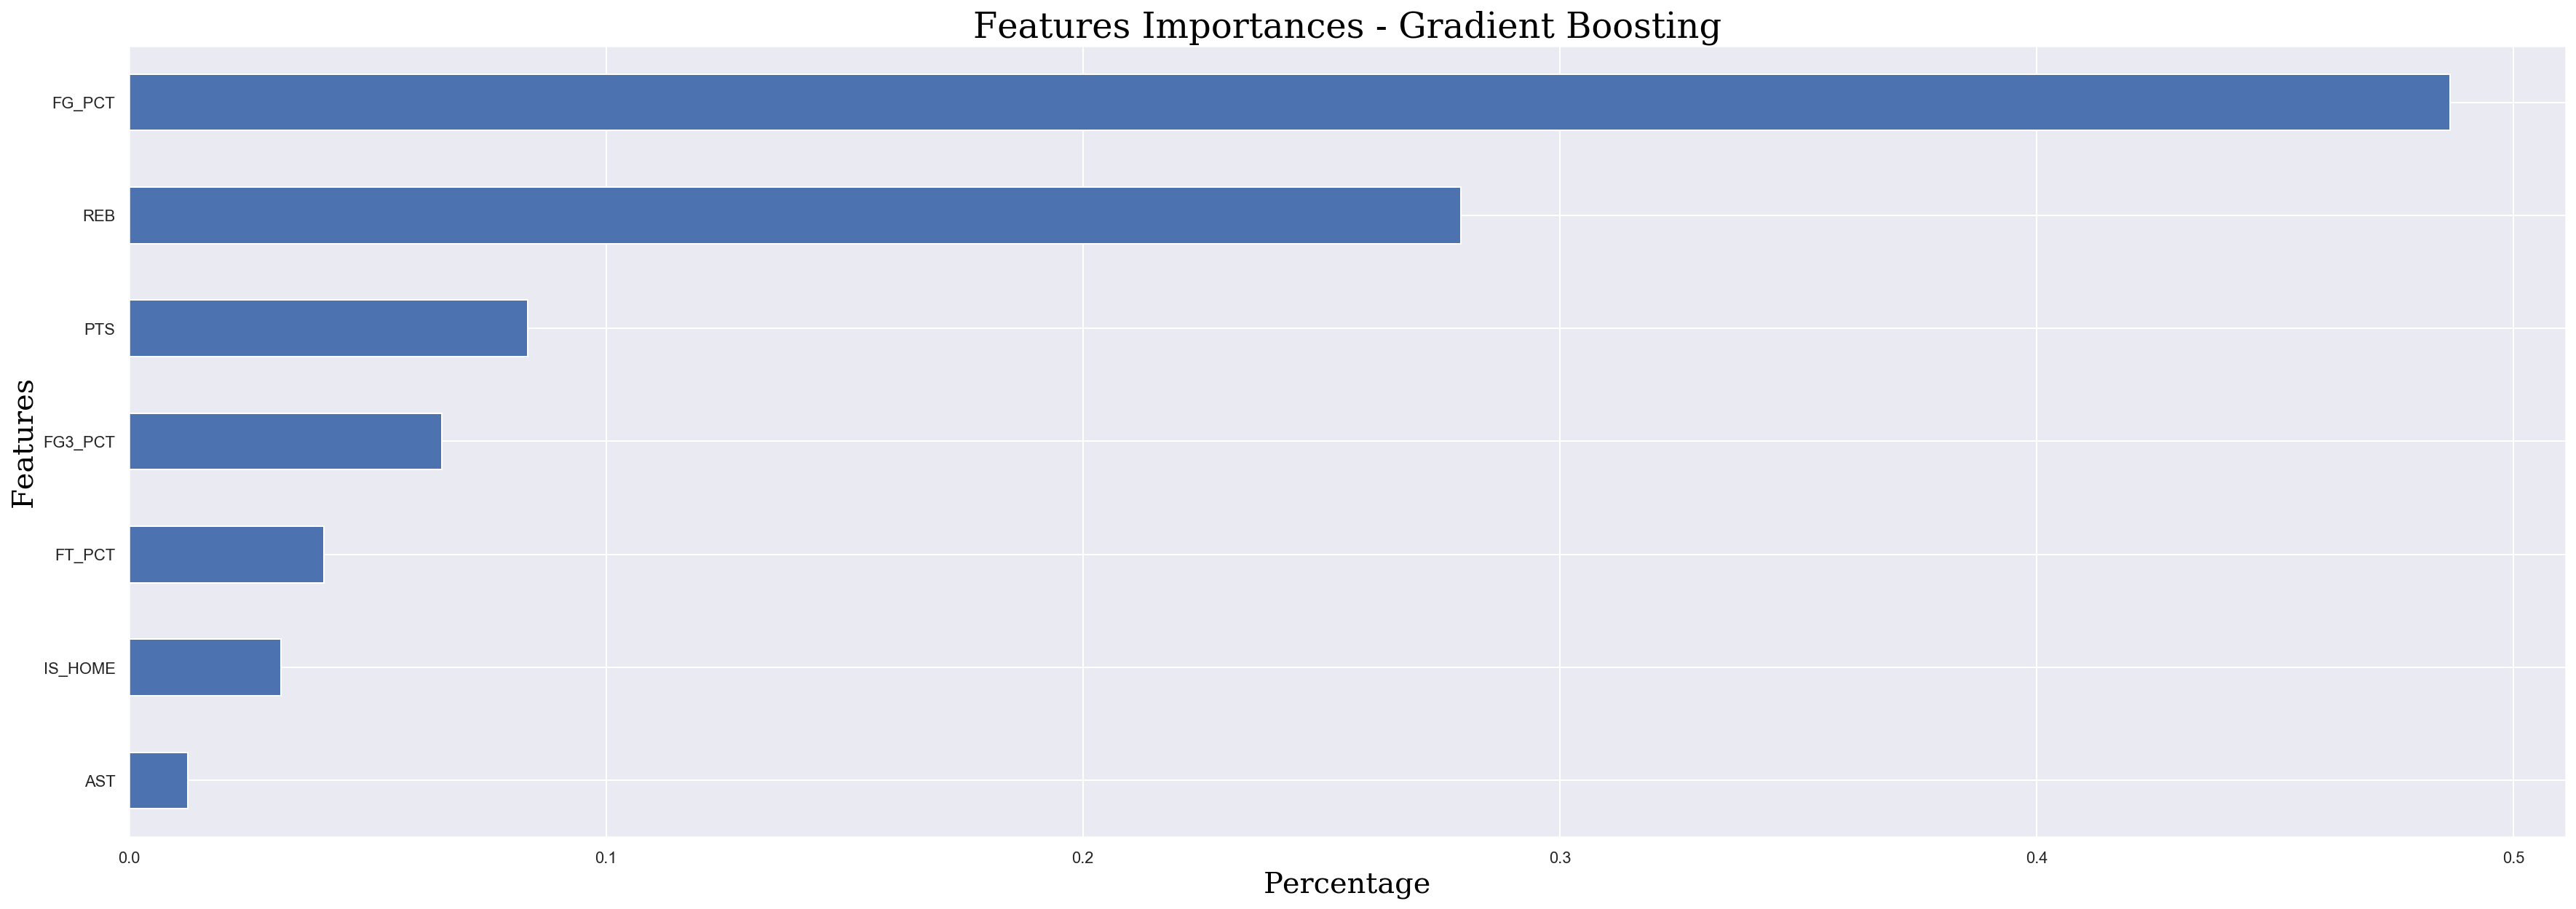

In [43]:
# Create a pd.Series of features importances
importances = pd.Series(data=gb.feature_importances_,
                        index= X_train.columns)

# Sort importances
importances_sorted = importances.sort_values()

# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh')
plt.title('Features Importances - Gradient Boosting', fontdict = font3)
plt.ylabel('Features', fontdict = font4)
plt.xlabel('Percentage', fontdict = font4)
plt.show()